# Load Data

In [51]:
import pandas as pd
import numpy as np
import matplotlib as mlt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [52]:
data = pd.read_csv('projectdata.xlsx - sheet 1.csv').rename(columns={'retail price' : 'retail_price', 'UnitePrice' : 'unit_price'})
data['date'] = pd.to_datetime(data['date']).dt.floor('d')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2995 entries, 0 to 2994
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   quantity      2995 non-null   int64              
 1   unit_price    2995 non-null   float64            
 2   discount      2995 non-null   float64            
 3   date          2995 non-null   datetime64[ns, UTC]
 4   retail_price  2995 non-null   float64            
 5   product_name  2995 non-null   object             
 6   area          2970 non-null   object             
 7   city          2995 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(3), int64(1), object(3)
memory usage: 187.3+ KB


NaNs only showed up in `area`

In [53]:
data.replace('product x ', 'product x', inplace= True)

- How many unique areas are there?

In [54]:
data.groupby('city')[['area']].nunique().sort_values('area', ascending=False)

area
city       
North    37
Cairo    19
Giza     14

In [55]:
data.groupby(['city', 'area'])[['quantity']].count().sort_values(by='quantity', ascending=False).value_counts()

quantity
1           9
2           8
3           4
7           3
13          3
16          2
29          2
20          2
82          2
18          2
11          2
8           2
5           2
4           2
68          2
300         1
272         1
158         1
151         1
148         1
121         1
109         1
99          1
89          1
87          1
49          1
79          1
59          1
57          1
55          1
51          1
46          1
35          1
30          1
23          1
17          1
15          1
301         1
Name: count, dtype: int64

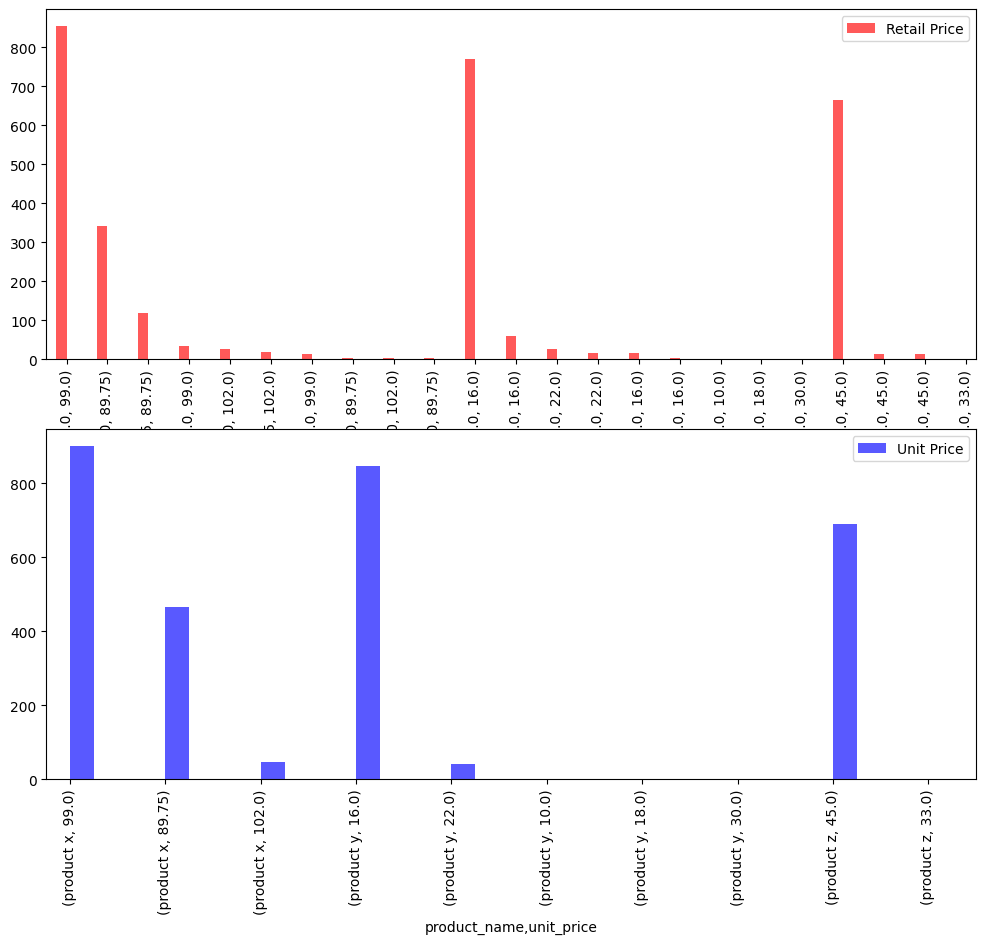

In [56]:
_, [ax1, ax2] = plt.subplots(2, 1, figsize= (12, 10))

_ = data.groupby(['product_name'])[['retail_price', 'unit_price']].value_counts().plot(kind= 'bar',
                                                                         color= 'red',
                                                                         ax= ax1,
                                                                         alpha= 0.65, 
                                                                         width= 0.25,
                                                                         position = 1,
                                                                         legend= True,
                                                                         label= 'Retail Price')

_ = data.groupby(['product_name'])[['unit_price']].value_counts().plot(kind= 'bar',
                                                                       color= 'blue',
                                                                       ax= ax2,
                                                                       alpha= 0.65,
                                                                       legend= True,
                                                                       width= 0.25,
                                                                       position = 0,
                                                                       label= 'Unit Price')

In [57]:
def get_correlation(df: pd.DataFrame) -> None:
    cities = df['city'].sort_values().unique().tolist()
    products = df['product_name'].sort_values().unique().tolist()

    method= 'pearson'
    corr = df.corr(method= method, numeric_only= True)
    _, ax_corr = plt.subplots(figsize= (5, 5))

    sns.heatmap(corr, annot= True, cmap= 'coolwarm', ax= ax_corr)
    ax_corr.set_title(f"{method.capitalize()} correlation for all dataset")

    _, axs = plt.subplots(3, 3, figsize=(18, 15))
    axs = axs.flatten()
    ax_idx = 0
    for city in cities:
        for product in products:
            temp = df.query("city == @city and product_name == @product")
            ax = axs[ax_idx]

            corr = temp.corr(method= method, numeric_only= True)
            sns.heatmap(corr, annot= True, cmap= 'coolwarm', ax= ax)
            ax.set_title(f"{method.capitalize()} correlation for {product} in {city}")
            ax_idx += 1

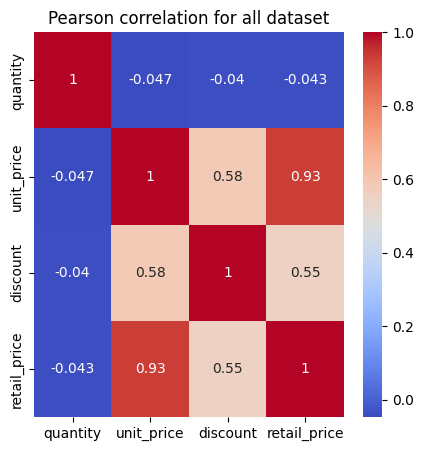

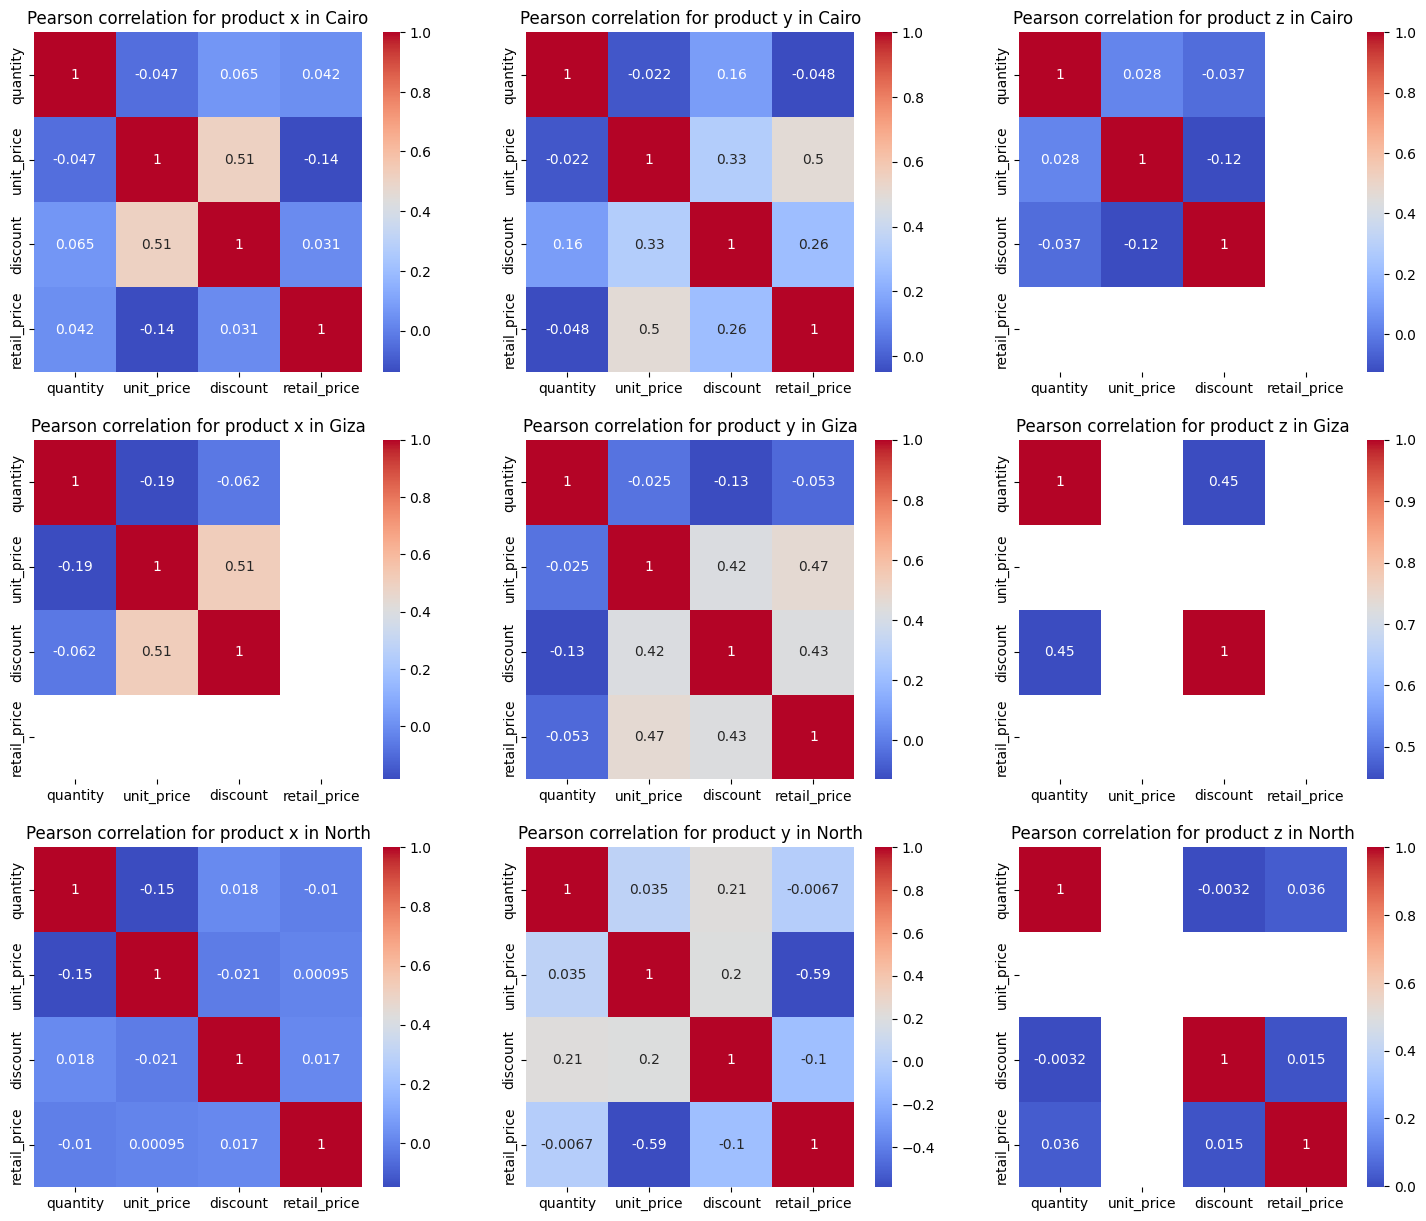

In [58]:
get_correlation(data)

1) These white bars in correlation are due to the value of that column having no variance.
2) From the above heat maps, we conclude that the prices and discount have no correlation with the target variable (quantity)

# EDA

In [59]:
data_grouped = data.groupby(['city', 'product_name', 'date'], as_index= False).sum()
data_grouped.drop(['discount', 'retail_price', 'area', 'unit_price'], axis= 1, inplace= True)
data_grouped.set_index('date', inplace= True)
data_grouped

city product_name  quantity
date                                                   
2021-03-31 00:00:00+00:00  Cairo    product x         5
2021-08-02 00:00:00+00:00  Cairo    product x         2
2021-08-19 00:00:00+00:00  Cairo    product x         3
2021-10-11 00:00:00+00:00  Cairo    product x        10
2021-10-20 00:00:00+00:00  Cairo    product x       100
...                          ...          ...       ...
2023-01-08 00:00:00+00:00  North    product z        18
2023-01-11 00:00:00+00:00  North    product z        17
2023-01-12 00:00:00+00:00  North    product z         7
2023-01-14 00:00:00+00:00  North    product z         1
2023-01-16 00:00:00+00:00  North    product z        11

[1532 rows x 3 columns]

In [60]:
data_grouped.describe()

quantity
count  1532.000000
mean     15.063969
std     140.538550
min       1.000000
25%       2.000000
50%       5.000000
75%      10.000000
max    5000.000000

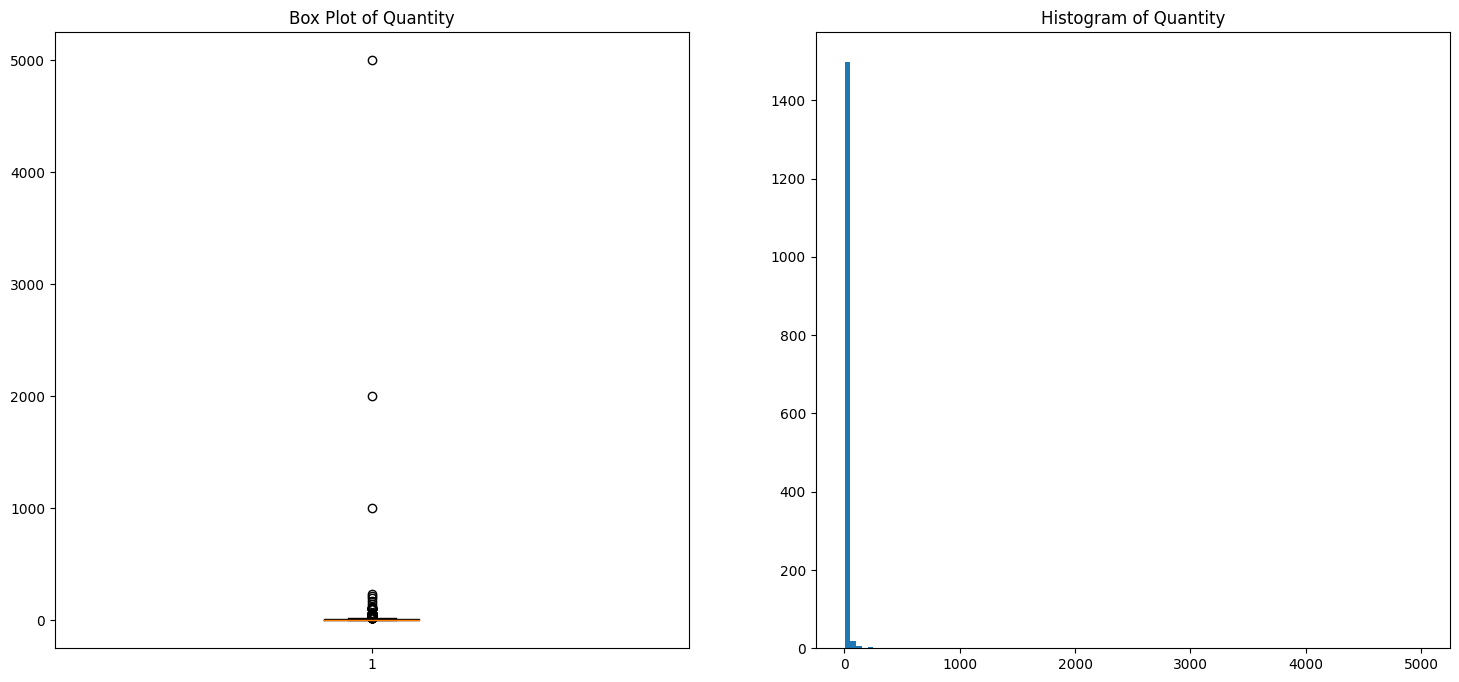

In [61]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize= (18, 8))

_ = ax1.boxplot(data_grouped['quantity'])
_ = ax2.hist(data_grouped['quantity'], bins= 100)
_ = ax1.set_title('Box Plot of Quantity')
_ = ax2.set_title('Histogram of Quantity')

## Handling Outliers

In [62]:
def drop_outliers(df: pd.DataFrame, percentage_of_IQR: int  = 1.5) -> pd.DataFrame:
    """
    Drop outliers from each product in each store depending on the following formula:
    1) `IQR` = Q3_75 - Q1
    2) `lower_bound` = Q1 - percentage_of_IQR * IQR
    3) `upper_bound` = Q3 + percentage_of_IQR * IQR
    """
    cities = df['city'].unique()
    products = df['product_name'].unique()

    df_outlier_free = df.reset_index().copy()
    result = []

    outliers_total = 0
    for city in cities:
        for product in products:
            df_filter = df_outlier_free.query('city == @city and product_name == @product').copy()
            Q1 = df_filter['quantity'].quantile(0.25)
            Q3 = df_filter['quantity'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = np.max([Q1 - percentage_of_IQR * IQR, 0])
            upper_bound = Q3 + percentage_of_IQR * IQR

            number_of_outliers = df_filter.query('quantity < @lower_bound or quantity > @upper_bound').shape[0]
            outliers_total += number_of_outliers
            print(f'City: {city}, Product: {product} || Bounds: [{lower_bound}, {upper_bound}] || Number of outliers: {number_of_outliers}')

            result.append( df_filter.query('quantity >= @lower_bound and quantity <= @upper_bound') )
            
    print(f"\nRemoved {outliers_total} ({outliers_total / df.shape[0]:.3f}%) outliers from dataset.")
    return pd.concat(result, ignore_index= True).set_index('date').sort_values(['city', 'product_name'])

In [63]:
outlier_free_df = drop_outliers(data_grouped, percentage_of_IQR= 1.25)

City: Cairo, Product: product x || Bounds: [0.0, 17.75] || Number of outliers: 24
City: Cairo, Product: product y || Bounds: [0.0, 30.0] || Number of outliers: 13
City: Cairo, Product: product z || Bounds: [0.0, 11.0] || Number of outliers: 11
City: Giza, Product: product x || Bounds: [0.0, 20.0] || Number of outliers: 17
City: Giza, Product: product y || Bounds: [0.0, 38.75] || Number of outliers: 12
City: Giza, Product: product z || Bounds: [0.0, 14.8125] || Number of outliers: 7
City: North, Product: product x || Bounds: [0.0, 16.5] || Number of outliers: 25
City: North, Product: product y || Bounds: [0.0, 31.3125] || Number of outliers: 19
City: North, Product: product z || Bounds: [0.0, 15.5] || Number of outliers: 19

Removed 147 (0.096%) outliers from dataset.


In [64]:
data_grouped.shape, outlier_free_df.shape #Before and After

((1532, 3), (1385, 3))

In [65]:
outlier_free_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1385 entries, 2021-03-31 00:00:00+00:00 to 2023-01-16 00:00:00+00:00
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   city          1385 non-null   object
 1   product_name  1385 non-null   object
 2   quantity      1385 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 43.3+ KB


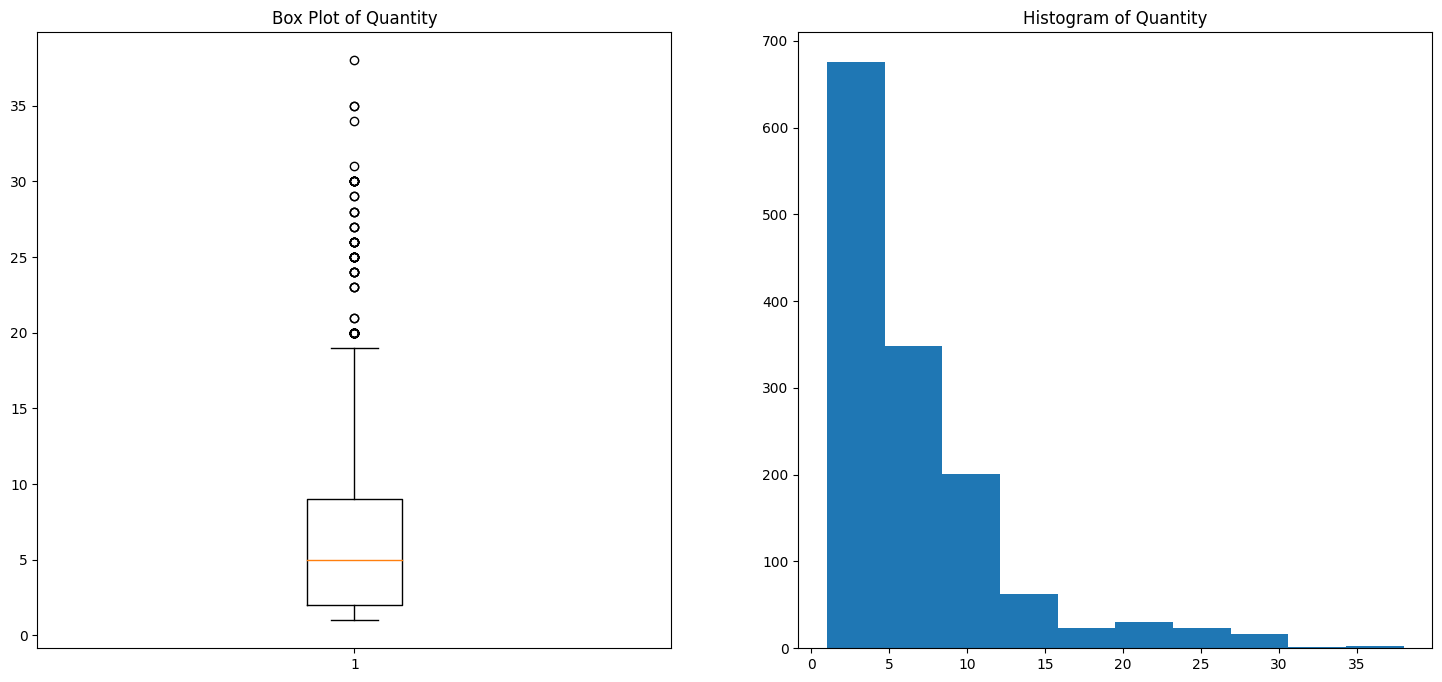

In [66]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize= (18, 8))

_ = ax1.boxplot(outlier_free_df['quantity'])
_ = ax2.hist(outlier_free_df['quantity'], bins= 10)
_ = ax1.set_title('Box Plot of Quantity')
_ = ax2.set_title('Histogram of Quantity')

Now that we have our **free of outliers** aggregated data for **the sold quantity** of **each product** in **each city** per **hour**, we can plot the time series for each product in each city.

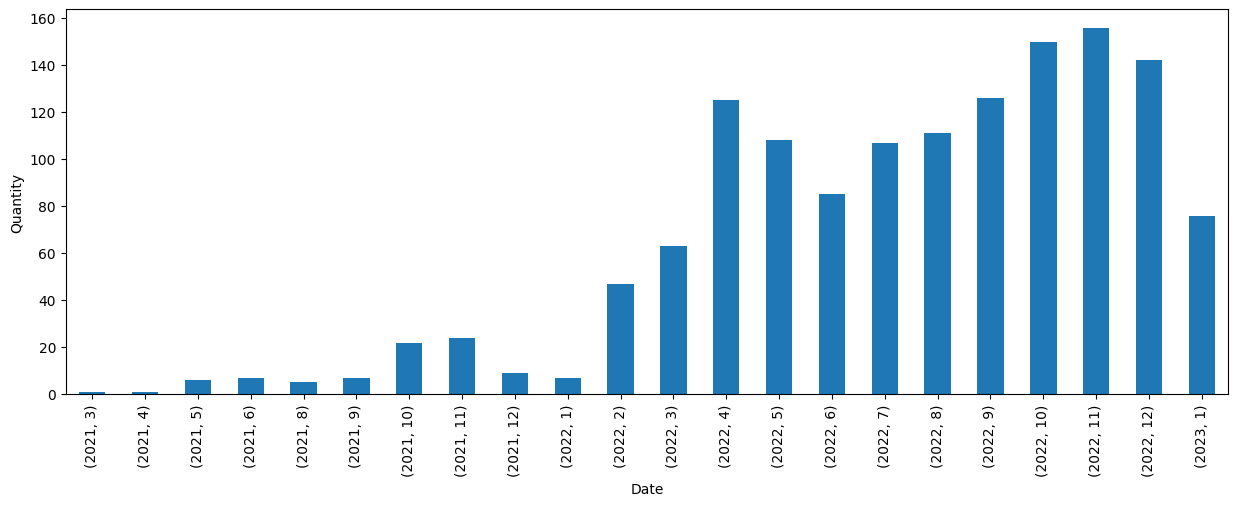

In [67]:
_ = outlier_free_df.groupby([outlier_free_df.index.year, outlier_free_df.index.month])[['quantity']].count().plot(kind='bar',
                                                                                                                  figsize=(15, 5),
                                                                                                                  xlabel= 'Date',
                                                                                                                  ylabel= 'Quantity',
                                                                                                                  legend= False)

We notice that: 2021 is poorly represented in our dataset, therefore, we can drop those values and consider only 2022 and 2023 for training and testing.

In [68]:
cleaned_data = outlier_free_df.query('date.dt.year >= 2022')

cities = cleaned_data['city'].unique().tolist()
products = cleaned_data['product_name'].unique().tolist()

In [69]:
def plot_original_timeseries_per_city(df: pd.DataFrame, city):
    _ , axs = plt.subplots(3, 1, figsize= (18, 10), dpi= 128)
    axs= axs.flatten()
    date_range = pd.date_range(start= df.index.min(), end= df.index.max(), freq= 'd')
    ax_idx = 0
    gaps_per_product = {}
    for product in products:
        ax = axs[ax_idx]
        temp = df.query('city == @city & product_name == @product').copy()
        date_range = pd.date_range(start= temp.index.min(), end= temp.index.max(), freq= 'd')
        temp = temp.reindex(date_range)
        gaps = temp[temp['quantity'].isna()]
        ax.set_title(f'Product: {product} - City: {city}')
        _ = ax.vlines(gaps.index, ymin= temp['quantity'].min(), ymax= temp['quantity'].max(),  color= 'red', alpha=0.25, linewidth= 1)
        _ = ax.plot(temp.index, temp['quantity'], label= product, marker= 'o', markersize= 3)
        ax_idx += 1
        gaps_per_product[f'Total missing values of {product} in {city}'] = f'{len(gaps) / len(temp) * 100:.2f}%'
    plt.show()
    return gaps_per_product

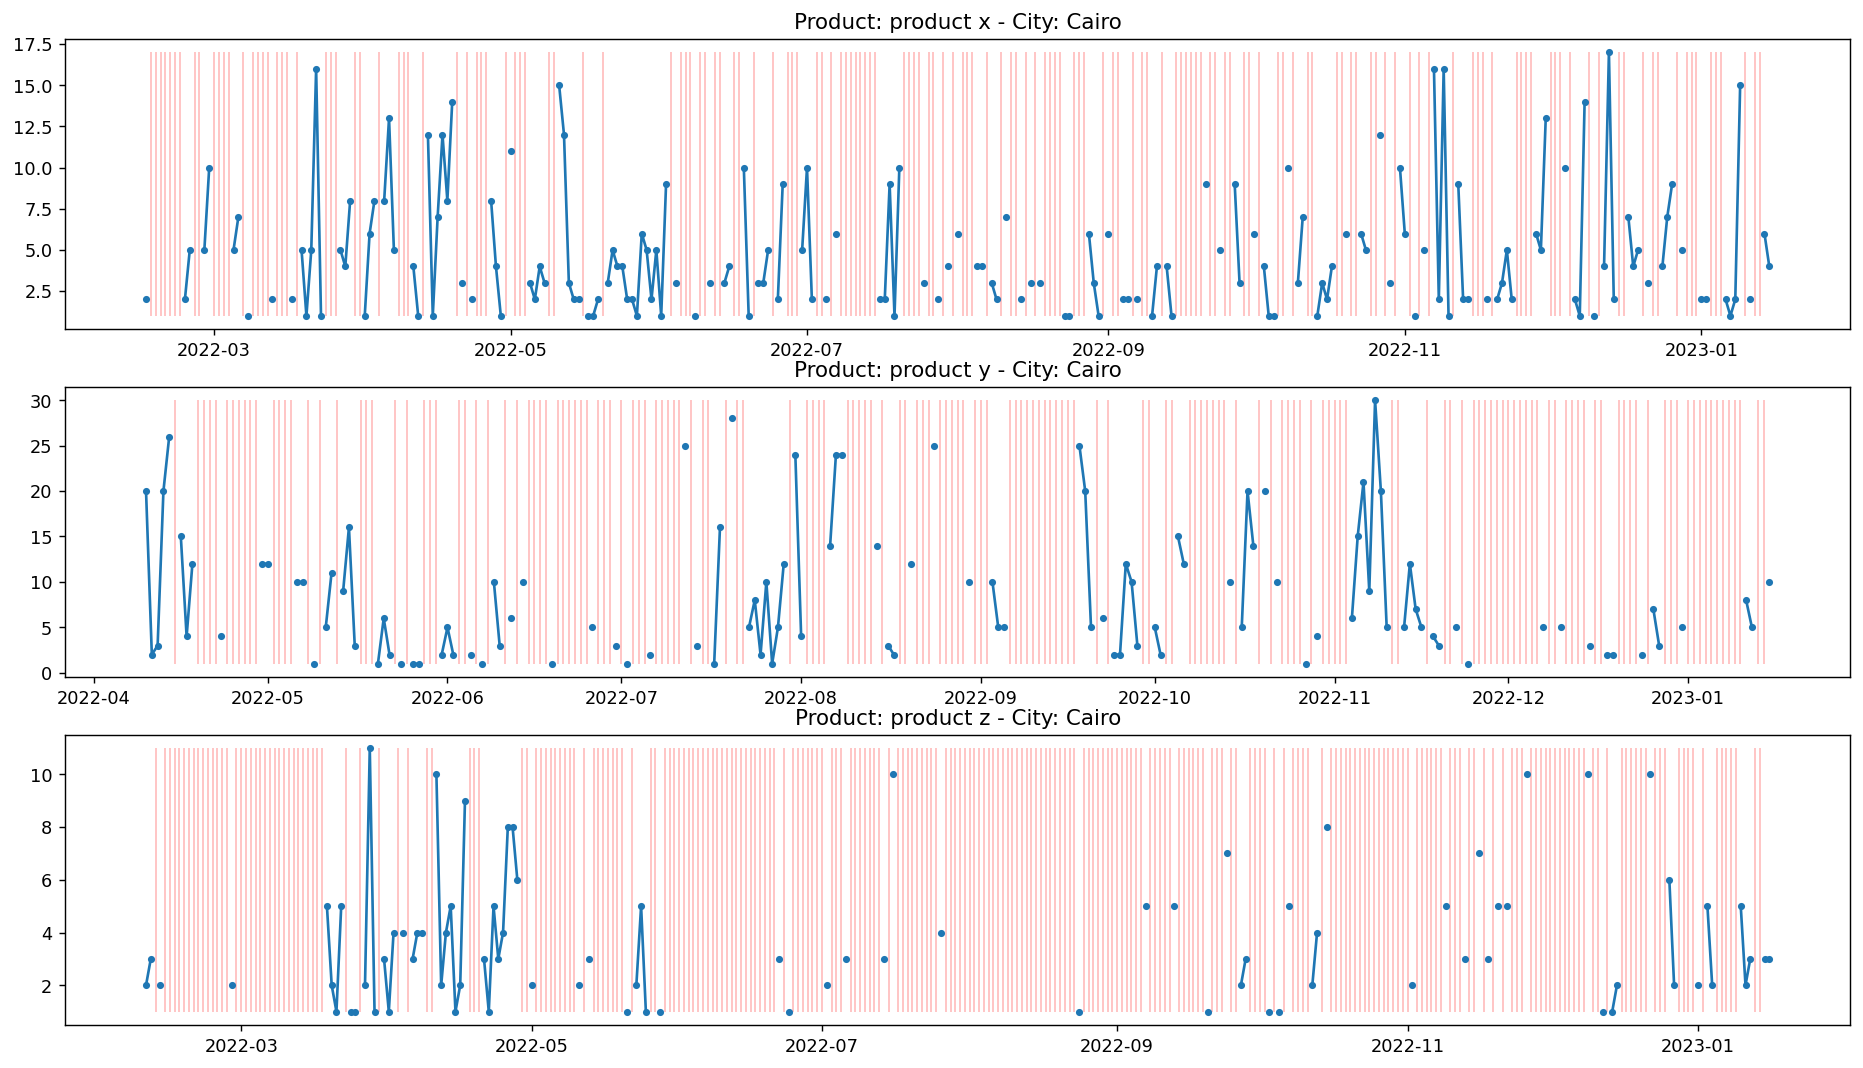

{'Total missing values of product x in Cairo': '48.06%', 'Total missing values of product y in Cairo': '59.79%', 'Total missing values of product z in Cairo': '74.85%'}


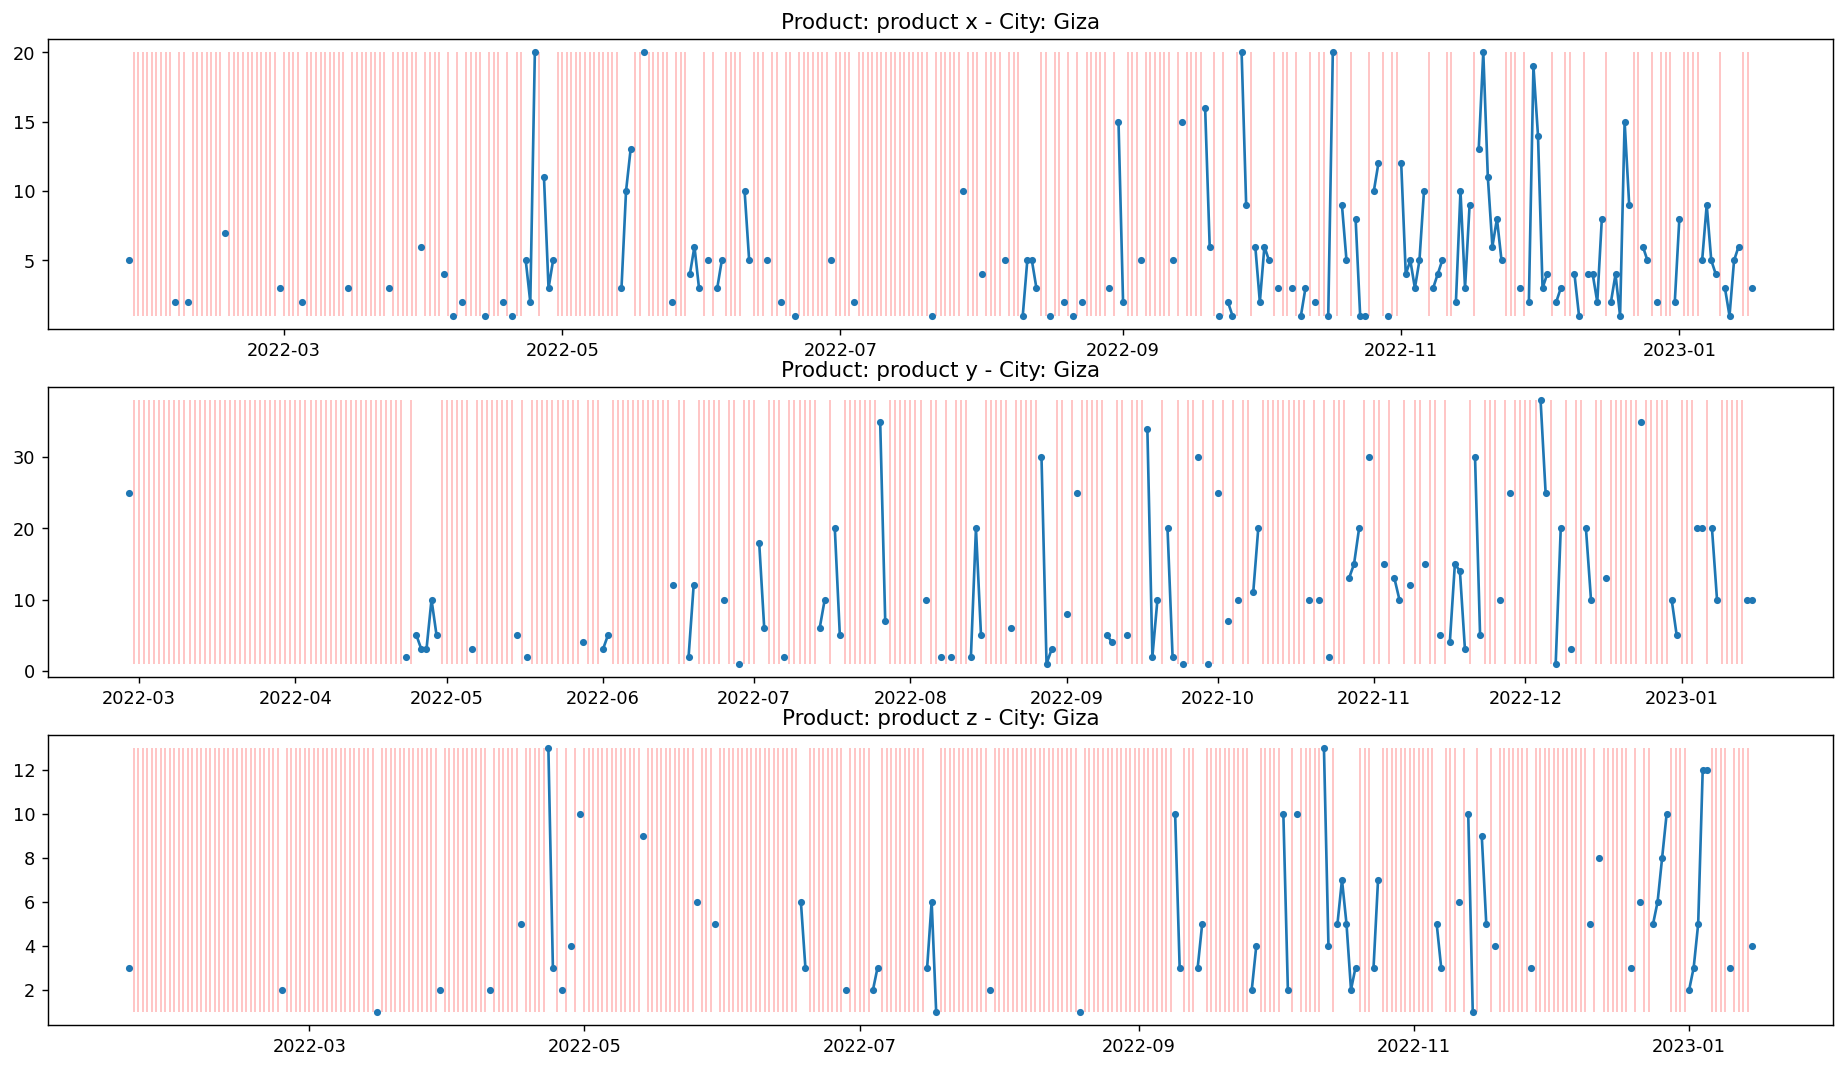

{'Total missing values of product x in Giza': '62.18%', 'Total missing values of product y in Giza': '71.21%', 'Total missing values of product z in Giza': '81.72%'}


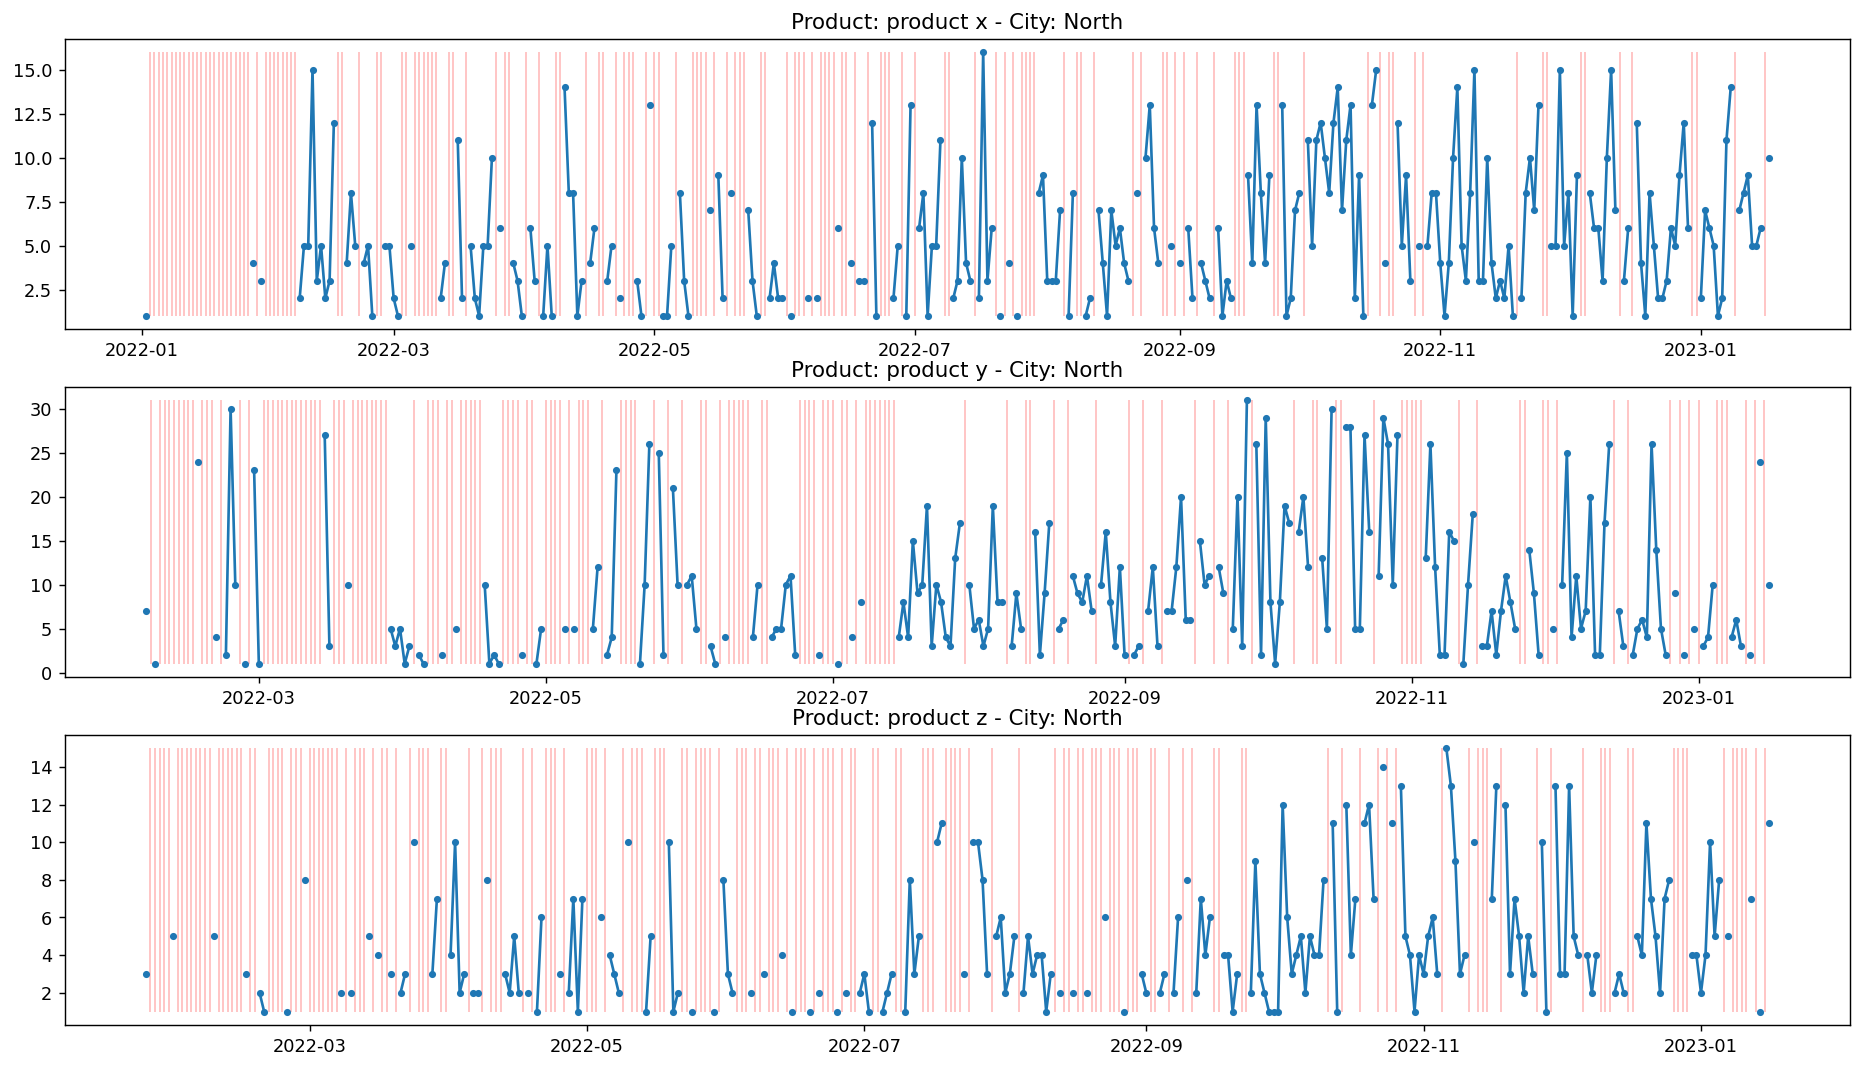

{'Total missing values of product x in North': '37.01%', 'Total missing values of product y in North': '41.33%', 'Total missing values of product z in North': '46.09%'}


In [70]:
for city in cities:    
    gaps = plot_original_timeseries_per_city(cleaned_data, city)
    print(gaps)

Here we notice a lot of missing values in each time series

In [71]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

def calculate_pacf(df: pd.DataFrame, city, product, ax):
    temp = df.query('city == @city & product_name == @product').copy()
    date_range = pd.date_range(start= temp.index.min(), end= temp.index.max(), freq= 'd')
    temp_q = temp['quantity']
    temp_q = temp_q.reindex(date_range).fillna(0)
    plot_pacf(temp_q, lags= 30, ax= ax)

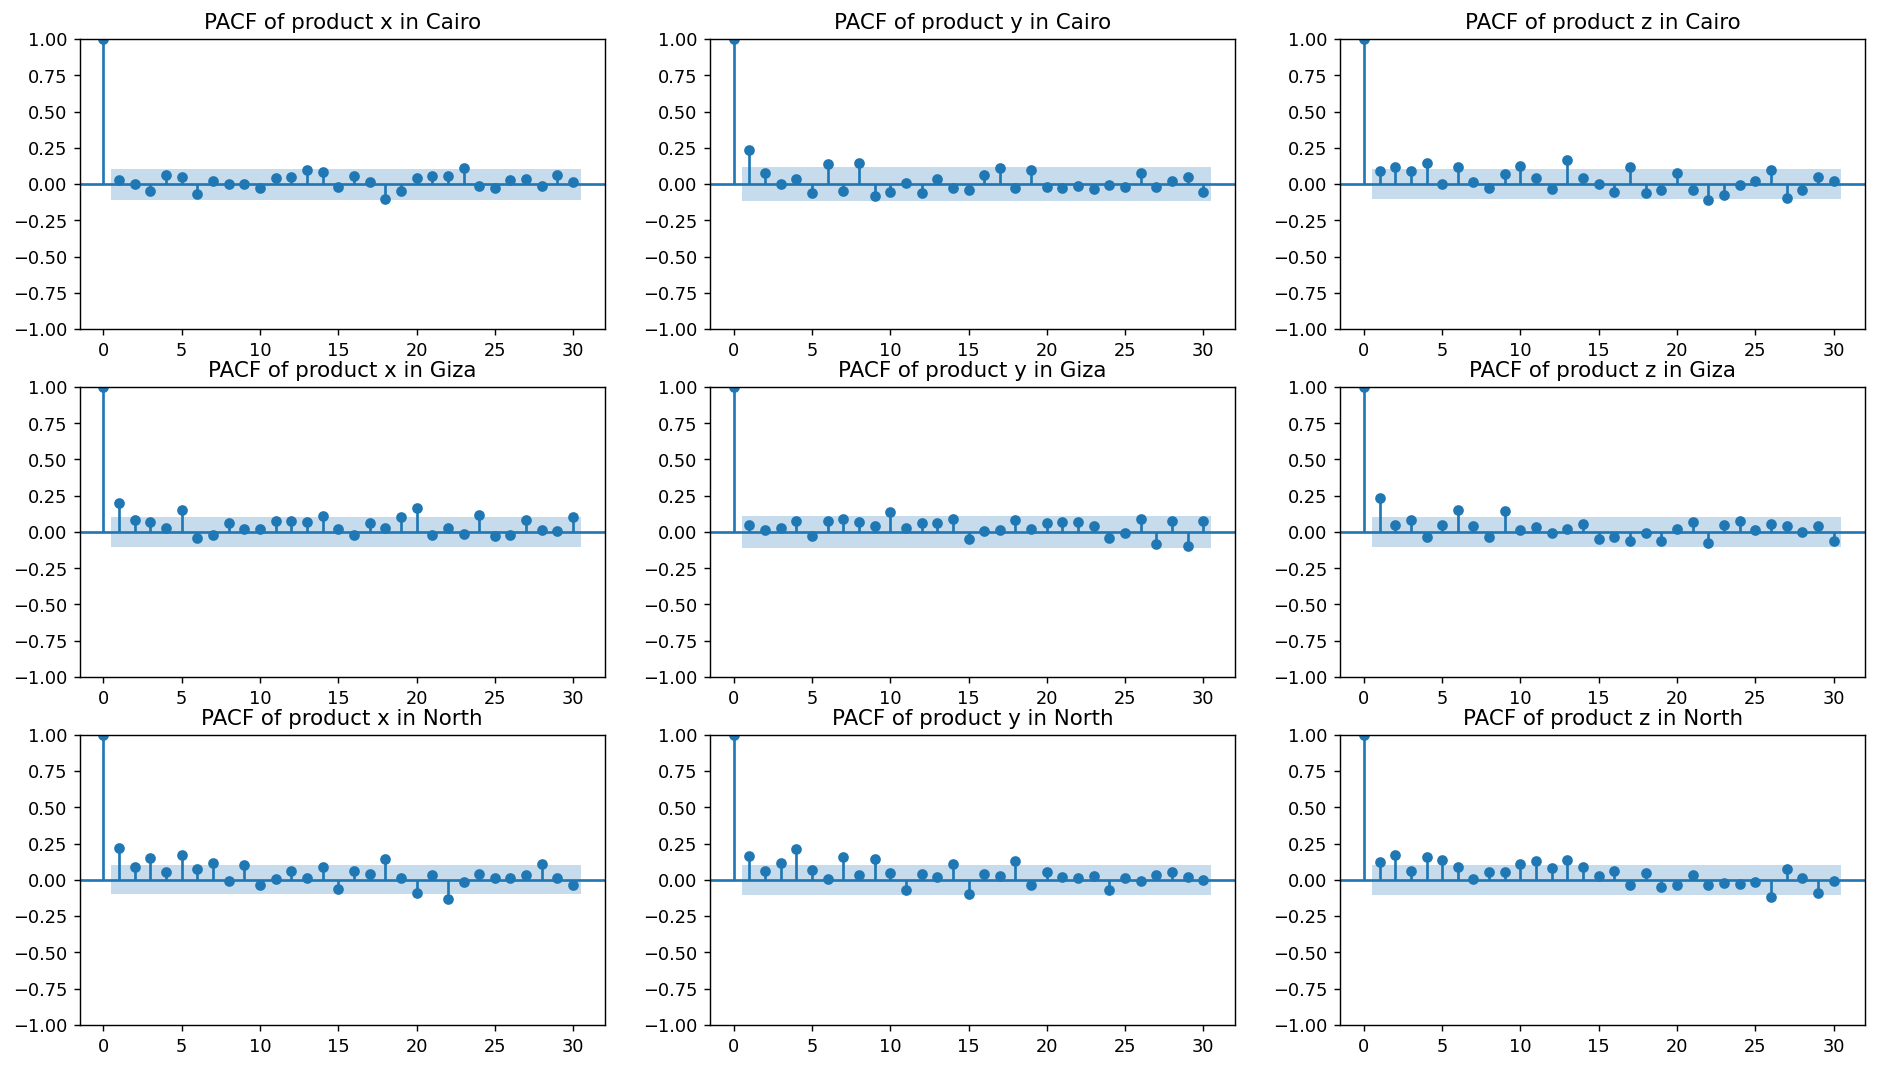

In [72]:
fig, axs = plt.subplots(3, 3, figsize= (18, 10), dpi= 128)
axs = axs.flatten()
ax_idx = 0
for city in cities:
    for product in products:
        ax = axs[ax_idx]
        calculate_pacf(cleaned_data, city, product, ax)
        ax.set_title(f'PACF of {product} in {city}')
        ax_idx += 1

- We don't get much from that, since we filled nans with zeros. <br>
- Another method is to interpolate the missing values linearly beforehand, but that led to the highest value being 1-lagged.

In [73]:
def calculate_stationarity(df: pd.DataFrame, city, product):
    temp = df.query('city == @city & product_name == @product')
    temp = temp['quantity']
    adf = adfuller(temp)
    if adf[1] < 0.05:
        print(f'{city} - {product} -> Stationary')
    else:
        print(f'{city} - {product} -> Non-Stationary | p-value: {adf[1]:.4f}')

In [74]:
for city in cities:
    for product in products:
        calculate_stationarity(cleaned_data, city, product)

Cairo - product x -> Stationary
Cairo - product y -> Stationary
Cairo - product z -> Stationary
Giza - product x -> Stationary
Giza - product y -> Stationary
Giza - product z -> Stationary
North - product x -> Stationary
North - product y -> Stationary
North - product z -> Stationary


Based on pre-imputation data: All data is non stationary except for product y in the north.

In [75]:
from statsmodels.tsa.seasonal import MSTL, seasonal_decompose
from datetime import timedelta

def plot_ts_components(df: pd.DataFrame, city, product):
    ts = df.query('city == @city & product_name == @product')[['quantity']]
    date_range = pd.date_range(start= ts.index.min(), end= ts.index.max(), freq= 'd')
    ts = ts.reindex(date_range)
    #comps = MSTL(ts.interpolate(method= 'time'), periods= (7, 30)).fit()
    comps = seasonal_decompose(ts.interpolate(method= 'time'), model= 'additive')
    seasonal_comp = comps.seasonal

    peaks = seasonal_comp[seasonal_comp == max(seasonal_comp)]
    season = peaks.index[1] - peaks.index[0]

    fig = plt.figure(figsize= (20, 2))
    plt.plot(date_range, seasonal_comp)
    fig.suptitle(f'Seasonal Component of {product} in {city} || Seasonal Period: {season}')
    plt.show()    

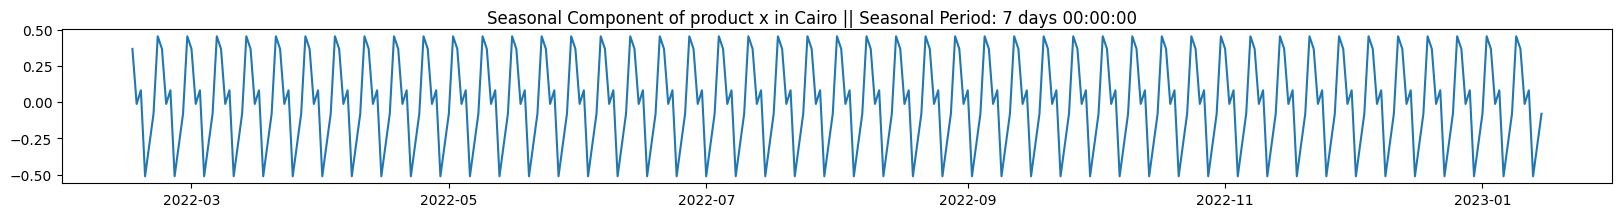

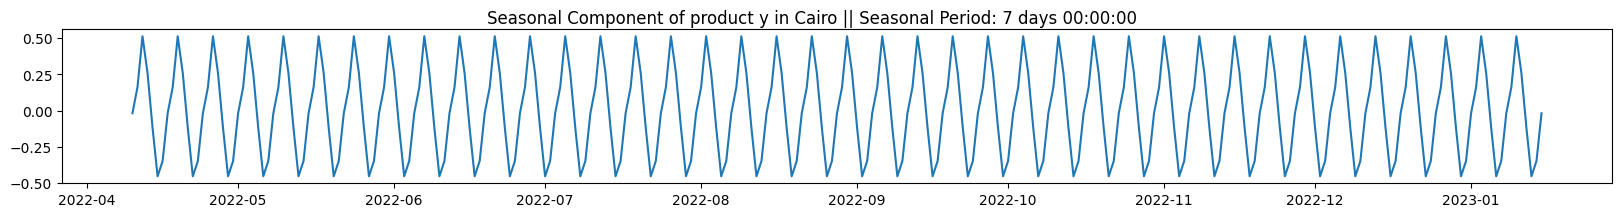

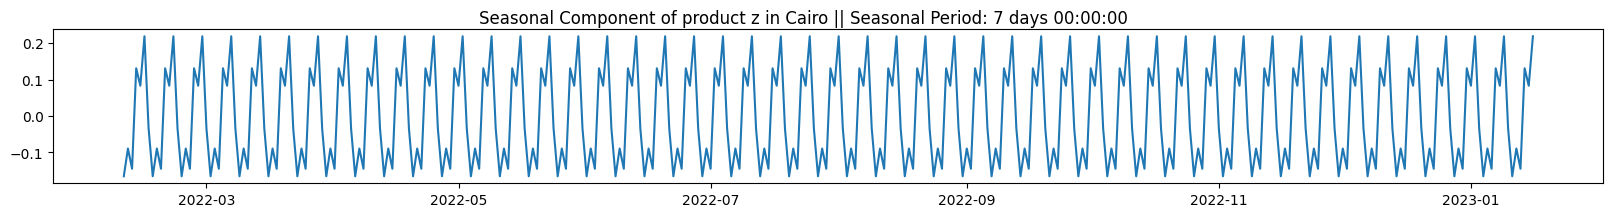

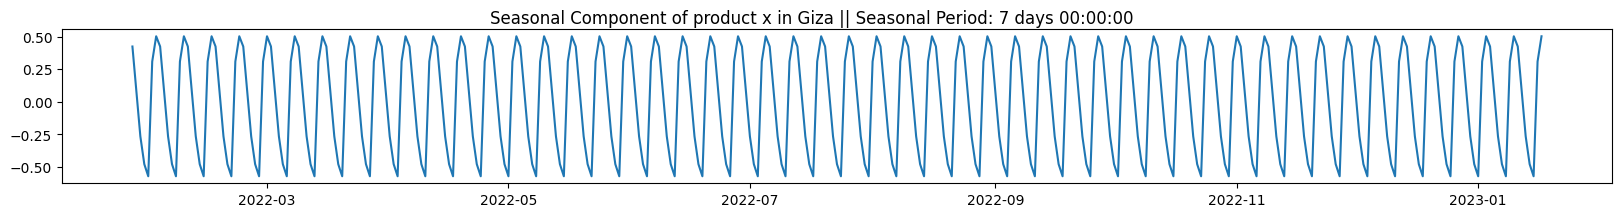

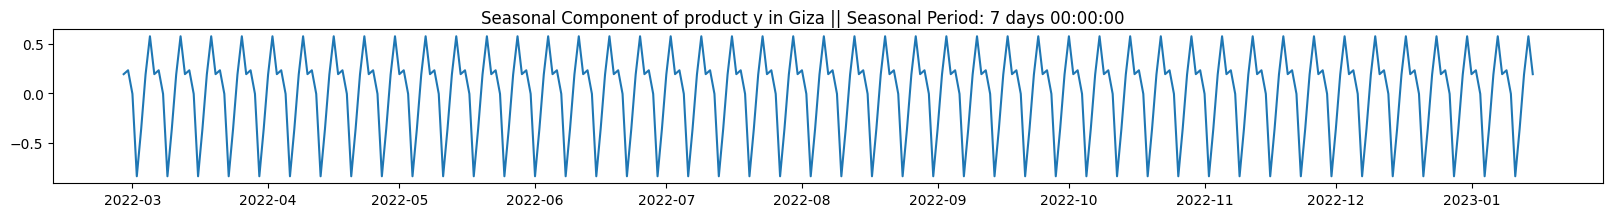

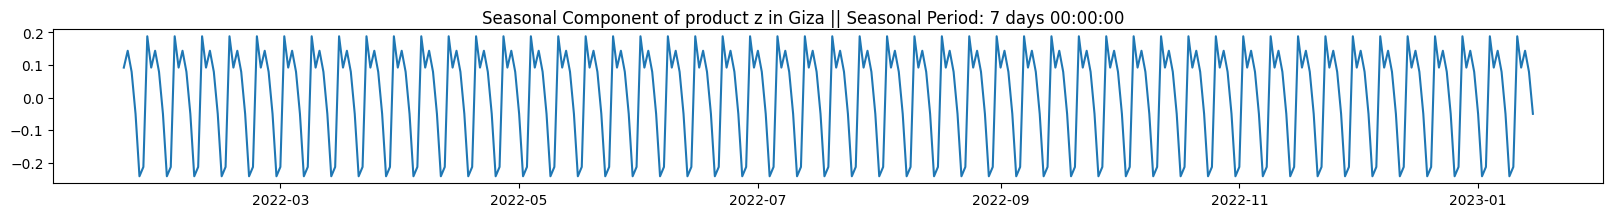

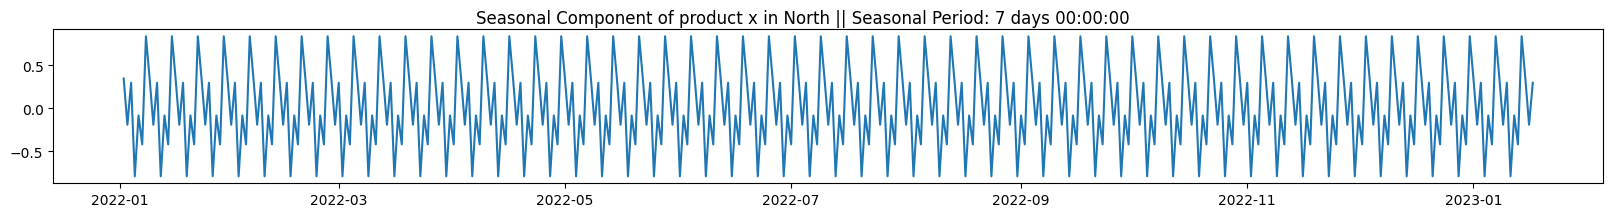

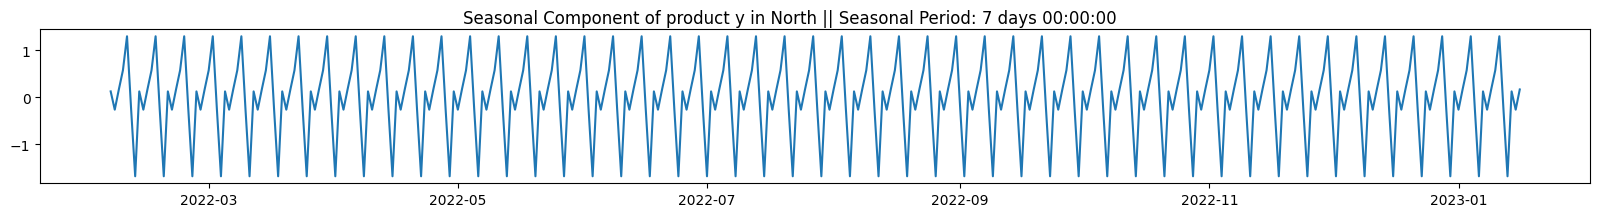

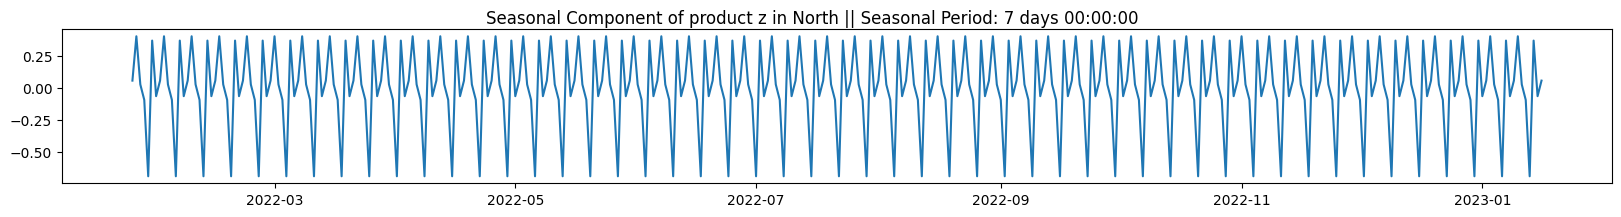

In [76]:
for city in cities:
    for product in products:
        plot_ts_components(cleaned_data, city, product)

All seasons are **7 days**.

## Data Interpolation

In [77]:
from typing import Literal
def interpolate_data(df: pd.DataFrame, cities, products, method: Literal['zeros', 'linear']) -> tuple:
    result = []

    for city in cities:
        for product in products:
            temp = df.query('city == @city and product_name == @product').copy()

            d_range = pd.date_range(start= temp.index.min(), end= temp.index.max(), freq= 'd')

            temp = temp.reindex(d_range)
            temp['was_missing'] = np.where(temp['quantity'].isna(), 1, 0)
            if method == 'zeros':
                temp['quantity'] = temp['quantity'].fillna(0)
            else:
                temp['quantity'] = temp['quantity'].interpolate(method= 'time')
            temp['city'] = city
            temp['product_name'] = product
            result.append(temp.reset_index())
    return pd.concat(result, ignore_index= True).set_index('index'), True

# Feature Engineering

### Choose which data to train & test on:
1. Original data.
2. Interpolated data.

In [78]:
def choose_data_type(df_org, decision: Literal['interpolated', 'original'], interpolation_method: Literal['zeros', 'linear'] = None, cities: list = None, products:list = None):
    if decision == 'interpolated':
        df, is_interpolated = interpolate_data(df_org, cities, products, method= interpolation_method)
    else:
        df = df_org.copy()
        is_interpolated = False

    return df, is_interpolated

In [79]:
interpolation_method = 'zeros'
decision = 'original'
final_data, is_interpolated = choose_data_type(cleaned_data, decision, interpolation_method, cities, products)

In [80]:
final_data['city'] = final_data['city'].astype('category')
final_data['product_name'] = final_data['product_name'].astype('category') 

## Feature Extraction

In [81]:
def create_temporal_features(df_org):
    df = df_org.copy()
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['day_sin'] = np.sin(2 * np.pi * df.index.day / 7)
    df['day_cos'] = np.cos(2 * np.pi * df.index.day / 7)
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x in [4, 5] else 0)
    df['gap'] = df.index.to_series().diff().dt.days.fillna(0)
    return df

In [82]:
final_data = create_temporal_features(final_data)
final_data.sort_index(inplace= True)

In [83]:
from datetime import timedelta

def create_lagged_stats(df_org: pd.DataFrame, periods_in_days: list, is_interpolated: bool) -> pd.DataFrame:
    """
    Create lagged statistics for a given period in the dataframe for each city and each product
    """
    df = df_org.copy()

    if isinstance(periods_in_days, int):
        periods_in_days = [periods_in_days]

    for period in periods_in_days:
        df[f'past_{period}_days_mean'] = 0.0
        df[f'past_{period}_days_std'] = 0.0
        df[f'past_{period}_days_max'] = 0.0
        df[f'past_{period}_days_min'] = 0.0

    for city in cities:
        for product in products:
            for period in periods_in_days:
                df.loc[:, f'past_{period}_days_mean'] = df['quantity'].rolling(window= timedelta(days= period), min_periods= 1, closed= 'left').mean().fillna(0)
                df.loc[:, f'past_{period}_days_std'] = df['quantity'].rolling(window= timedelta(days= period), min_periods= 1, closed= 'left').std().fillna(0)
                df.loc[:, f'past_{period}_days_max'] = df['quantity'].rolling(window= timedelta(days= period), min_periods= 1, closed= 'left').max().fillna(0)
                df.loc[:, f'past_{period}_days_min'] = df['quantity'].rolling(window= timedelta(days= period), min_periods= 1, closed= 'left').min().fillna(0)
    return df

In [84]:
periods = [7]
training_data = create_lagged_stats(final_data, periods_in_days= periods, is_interpolated= is_interpolated)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1303 entries, 2022-01-02 00:00:00+00:00 to 2023-01-17 00:00:00+00:00
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   city              1303 non-null   category
 1   product_name      1303 non-null   category
 2   quantity          1303 non-null   int64   
 3   day               1303 non-null   int32   
 4   month             1303 non-null   int32   
 5   day_of_week       1303 non-null   int32   
 6   day_of_year       1303 non-null   int32   
 7   day_sin           1303 non-null   float64 
 8   day_cos           1303 non-null   float64 
 9   is_weekend        1303 non-null   int64   
 10  gap               1303 non-null   float64 
 11  past_7_days_mean  1303 non-null   float64 
 12  past_7_days_std   1303 non-null   float64 
 13  past_7_days_max   1303 non-null   float64 
 14  past_7_days_min   1303 non-null   float64 
dtypes: category(2), float64(

# Training Forecasting Model

In [85]:
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

In [86]:
def generate_train_test_split(df: pd.DataFrame, is_interpolated: bool) -> pd.DataFrame:
    """
    Returns train-test split for the given dataframe where:
    - Training data is before 2023
    - Testing data is after 2023
    """
    df_sorted = df.copy().sort_index()
    if is_interpolated: df_sorted.drop('was_missing', axis= 1, inplace= True)
    X_train = df_sorted[df_sorted.index.year < 2023].drop('quantity', axis= 1)
    y_train = df_sorted[df_sorted.index.year < 2023]['quantity']
    X_test = df_sorted[df_sorted.index.year >= 2023].drop('quantity', axis= 1)
    y_test = df_sorted[df_sorted.index.year >= 2023]['quantity']
    
    return X_train, y_train, X_test, y_test

In [87]:
X_train, y_train, _, y_test = generate_train_test_split(training_data, is_interpolated)

#We don't actually care about X_test, only y_test is used for evaluation

### XGBRegressor

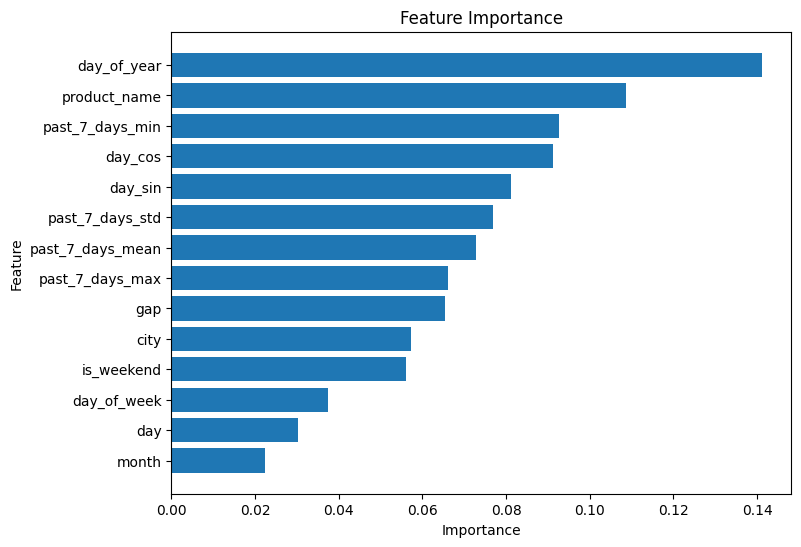

In [88]:
model = XGBRegressor(n_estimators= 3000,
                     max_depth= 30,
                     learning_rate= 0.19,
                     objective= 'reg:squarederror',
                     enable_categorical= True,
                     reg_lambda = 5,
                     random_state= 43).fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

### Fitting Training Set

In [89]:
def predict_whole_time_period(df: pd.DataFrame, model, periods, city, product, is_interpolated: bool, interpolation_method: Literal['zeros', 'linear'] = None):
    
    temp = df.query('city == @city and product_name == @product').copy()
    d_range = pd.date_range(start= temp.index.min(), end= temp.index.max(), freq= 'd')

    if not is_interpolated: #Then interpolate input for plotting

        temp = temp.reindex(d_range)
        temp['was_missing'] = np.where(temp['quantity'].isna(), 1, 0)
        if interpolation_method == 'zeros':
            temp['quantity'] = temp['quantity'].fillna(0)
        else:
            temp['quantity'] = temp['quantity'].interpolate(method= 'time')

        temp = create_temporal_features(temp)
        temp = create_lagged_stats(temp, periods, is_interpolated= is_interpolated)
    
    temp_test = temp.drop(['quantity', 'was_missing'], axis= 1)
    y_hat = np.clip(model.predict(temp_test), 0, np.inf)

    _ = plt.figure(figsize=(25, 3))

    plt.plot(d_range, temp['quantity'],
             marker= 'o',
             markersize= 2,
             alpha = 0.5,
             label= 'Actual Data')

    plt.scatter(temp[temp['was_missing'] == 1].index, temp[temp['was_missing'] == 1]['quantity'],
                color= 'red',
                marker= 'o',
                s= 2, 
                label= 'Filled Values',
                zorder = 3)

    plt.plot(d_range, y_hat,
             marker= 'o',
             markersize= 2,
             alpha= 0.5,
             color= 'green',
             label= 'Predicted Data')

    plt.legend()
    plt.title(f"Trained model for {product} in {city} || Filled values in the original time series = {temp[temp['was_missing'] == 1].shape[0] / temp.shape[0] * 100 :.3f}%")
    plt.ylabel('Quantity')

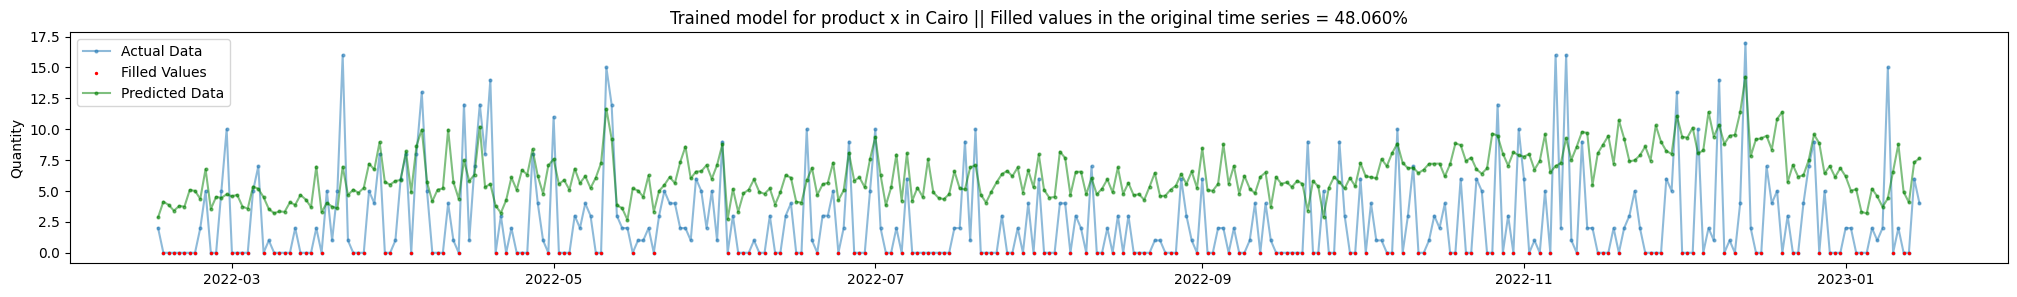

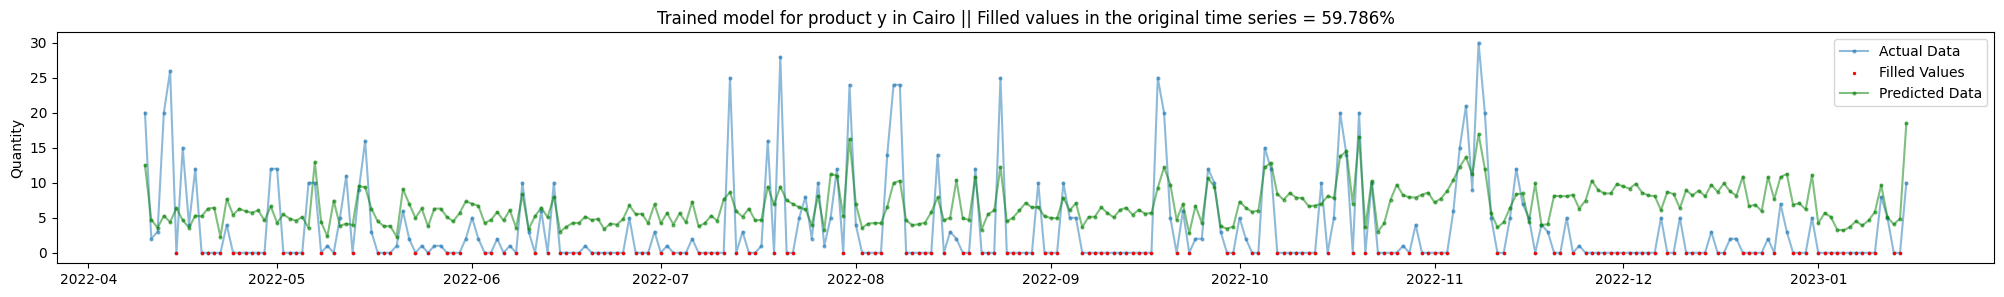

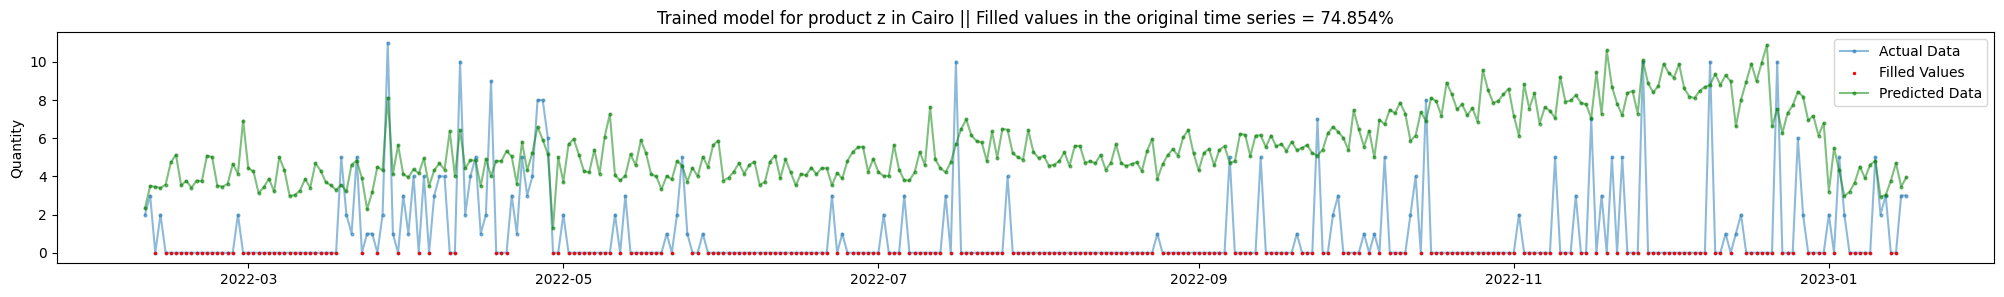

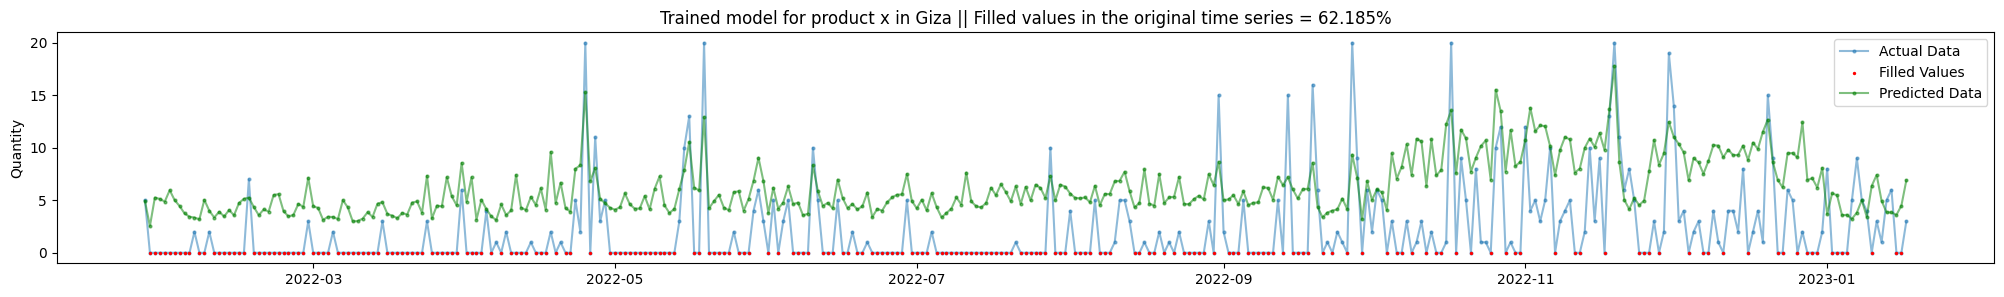

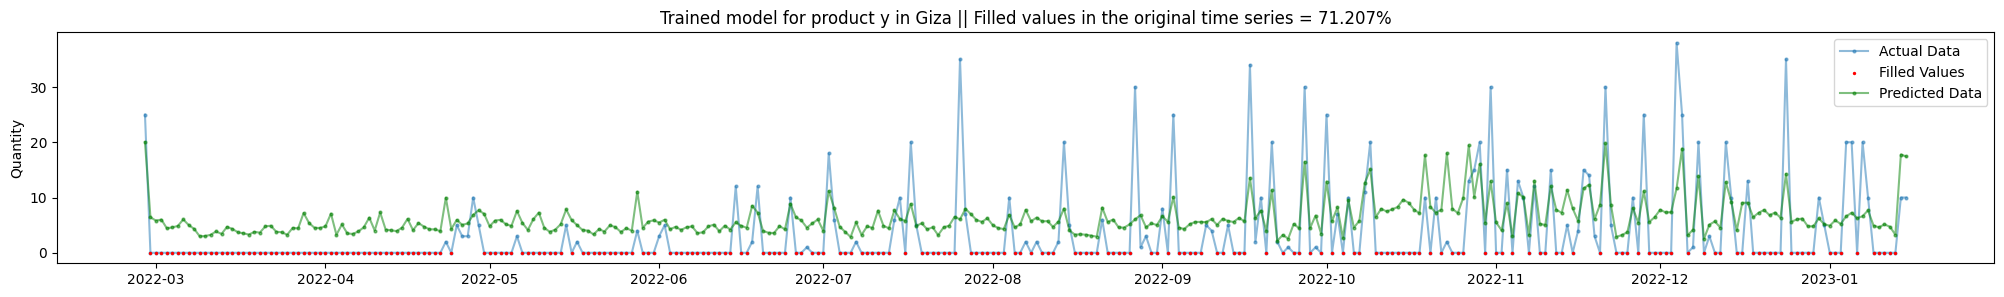

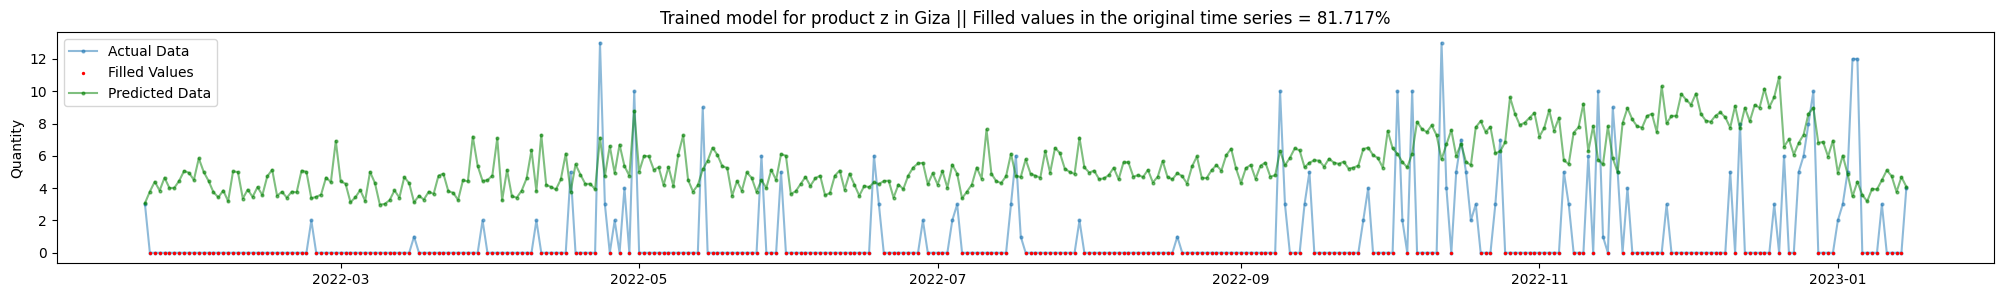

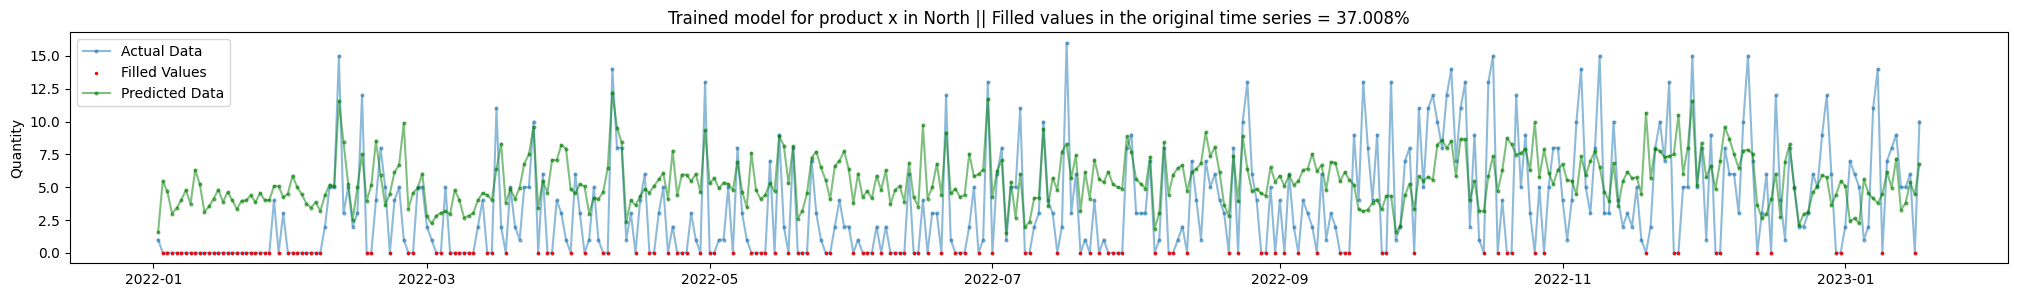

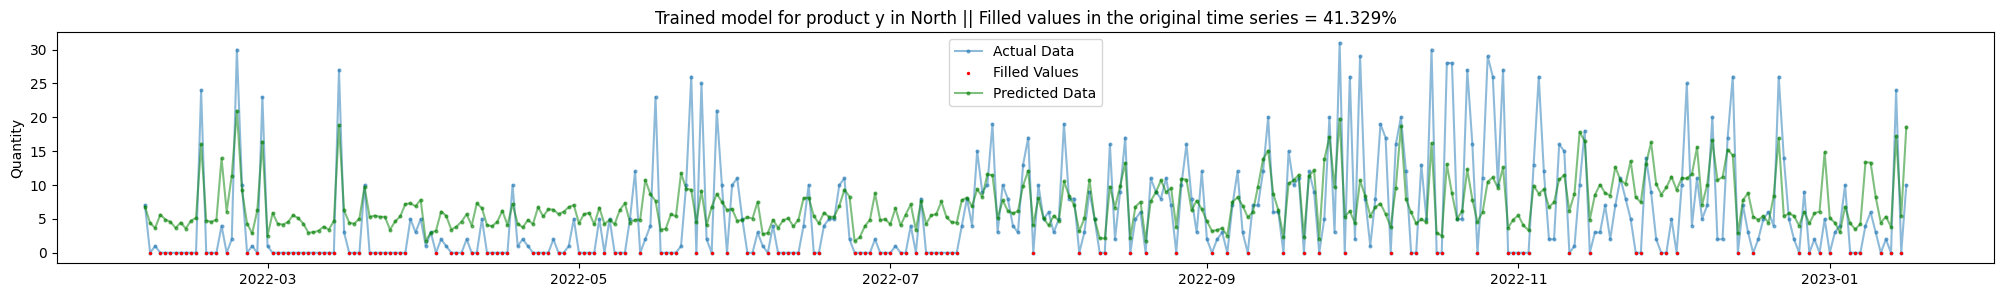

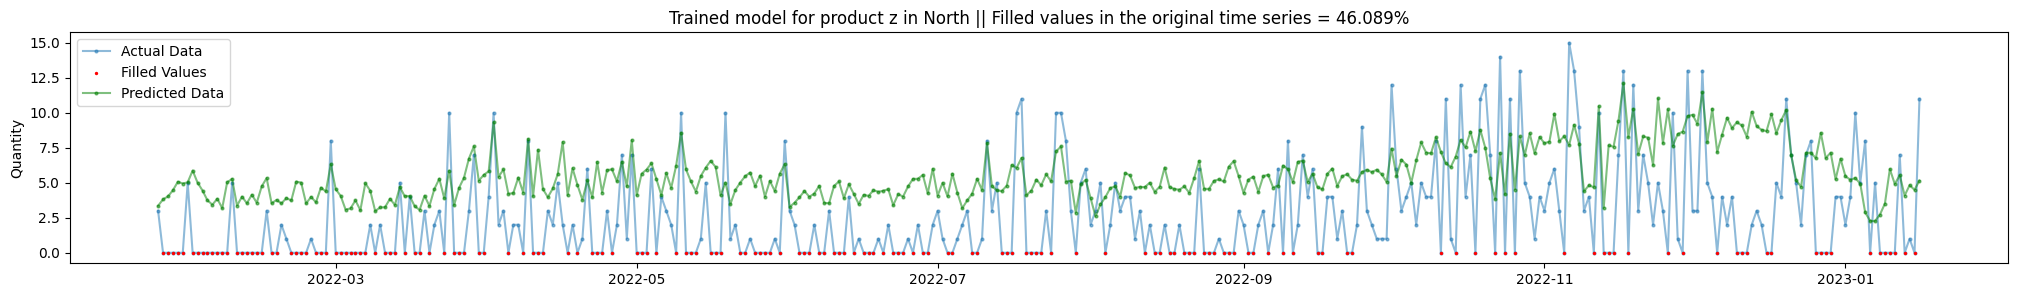

In [90]:
for city in cities:
    for product in products:
        if is_interpolated:
            predict_whole_time_period(training_data, model, periods, city, product, is_interpolated= True)
        else:
            predict_whole_time_period(training_data, model, periods, city, product, is_interpolated= False, interpolation_method= interpolation_method)

# Forecasting

In [91]:
def predict_one_step(x, model) -> int:
    """
    Forecast the quantity for the next day
    """
    y_hat = model.predict(x)
    return np.clip(y_hat[0], 0, np.inf)

In [92]:
def recursive_forecast(df: pd.DataFrame, model, windowing_periods, cities, products, is_interpolated: bool, n_days: int = 20) -> pd.DataFrame:
    """
    Recursively forecast the given target value in the dataframe using the model and n_days
    This process works by forecasting only one period ahead and then using the forecasted value to forecast the next period until n_days
    Inputs:
    - `df`: DataFrame containing the data to forecast, in our case we want to forecast the upcoming 10 days to the last date in the dataframe
    - `model`: Model to use for forecasting
    - `windowing_periods`: List of periods to use for lagged statistics
    - `cities`: List of cities to forecast
    - `products`: List of products to forecast
    - `scaler`: Scaler used to scale the data
    - `n_days`: Number of days to forecast
    """
    Y_hat = []
    for city in cities:
        for product in products:
            temp = df.query('city == @city & product_name == @product').copy()
            for _ in range(n_days):
                idx = pd.to_datetime(temp.index[-1] + pd.DateOffset(days= 1))
                temp.loc[idx, 'city'] = city
                temp['city'] = temp['city'].astype('category')
                temp.loc[idx, 'product_name'] = product
                temp['product_name'] = temp['product_name'].astype('category')
                temp.loc[[idx]] = create_temporal_features(temp.loc[[idx]])
                temp = create_lagged_stats(temp, periods_in_days= windowing_periods, is_interpolated= is_interpolated)
                temp.loc[idx, 'quantity'] = predict_one_step(temp.drop('quantity', axis= 1).tail(1), model)
                Y_hat.append({
                    'city': city,
                    'product_name': product,
                    'date' : idx,
                    'quantity': round(temp['quantity'].values[-1])
                })

    return pd.DataFrame(Y_hat).set_index('date')

In [93]:
predicted = recursive_forecast(pd.concat([X_train, y_train], axis= 1), model, periods, cities, products, is_interpolated= is_interpolated, n_days= 15)

### Testing on 2023 Data 

In [94]:
def plot_original_vs_forecast(original: pd.DataFrame, forecasted: pd.DataFrame, cities: list, products: list, start = -1, is_interpolated: bool = None):
    """
    Plot the original vs forecasted values for the given dataframe
    """
    if start == -1:
        start = org.index.min()
    else:
        start = pd.Timestamp(start, tz='UTC')
        
    for city in cities:
        for product in products:
            predicted = forecasted.query('city == @city & product_name == @product').copy()
            _ , ax = plt.subplots(1, 1, figsize= (18, 5))
            org = original.query('city == @city & product_name == @product').copy()
            date_range = pd.date_range(start= start, end= predicted.index.max(), freq= 'd')
            org = org.reindex(date_range)
            predicted = predicted.reindex(date_range)

            _ = ax.plot(org['quantity'],
                        label= 'Actual', 
                        color= 'blue',
                        marker= 'o',
                        markersize= 4)

            _ = ax.plot(predicted['quantity'],
                        label= 'Forecasted',
                        color= 'green',
                        marker= 'o',
                        markersize= 2)

            if is_interpolated:
                plt.scatter(org[org['was_missing'] == 1].index, org[org['was_missing'] == 1]['quantity'],
                            color= 'red',
                            marker= 'o',
                            s= 4, 
                            label= 'Filled Values',
                            zorder = 2)

            _ = ax.set_title(f'City: {city} - Product: {product}')
            _ = ax.legend()

            plt.show()

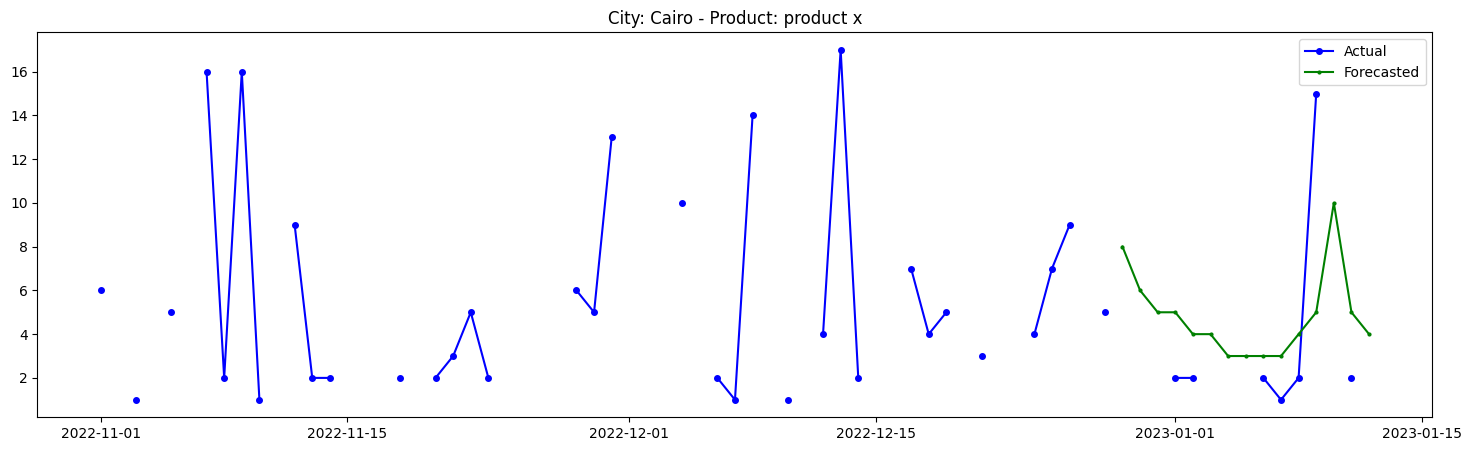

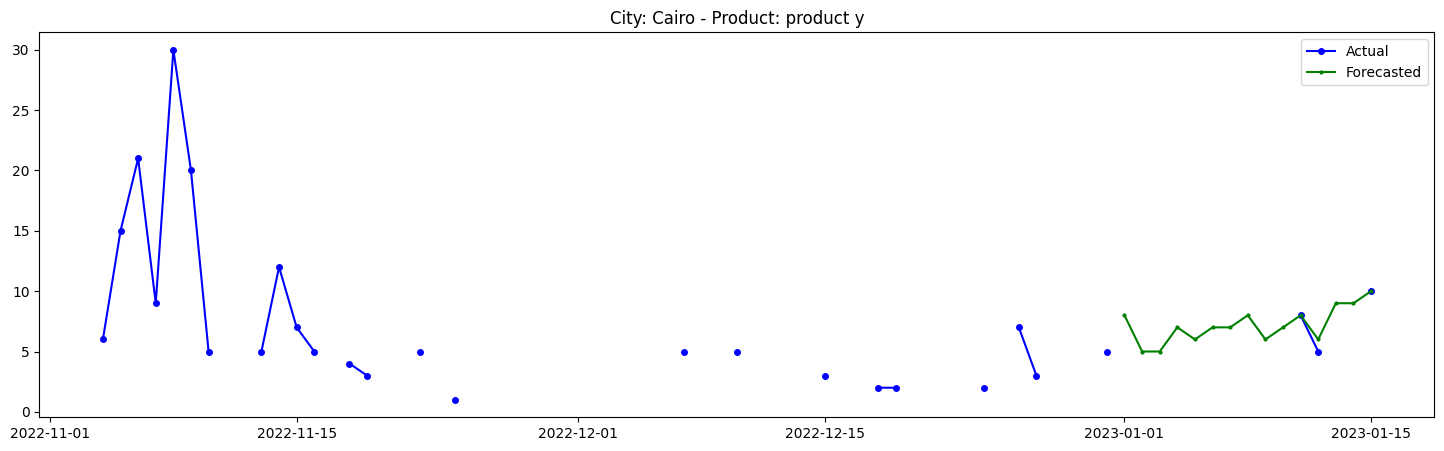

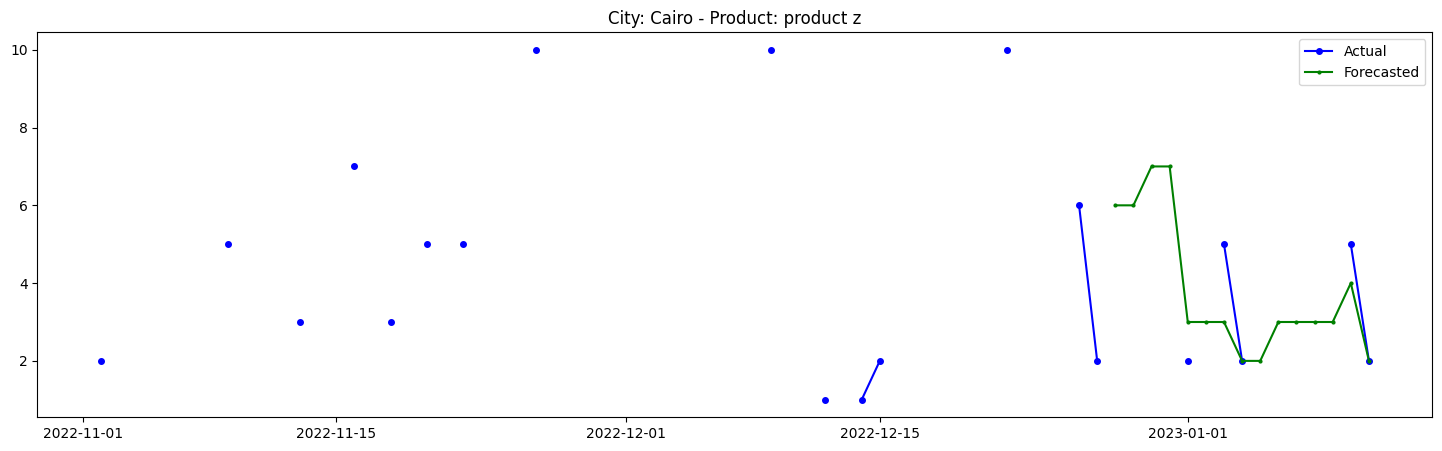

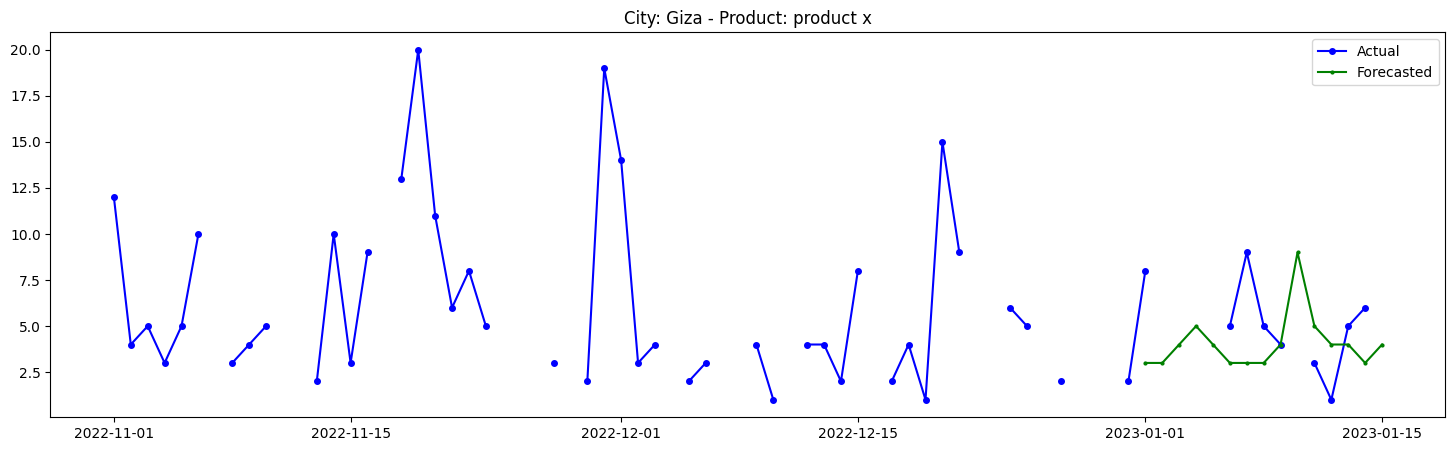

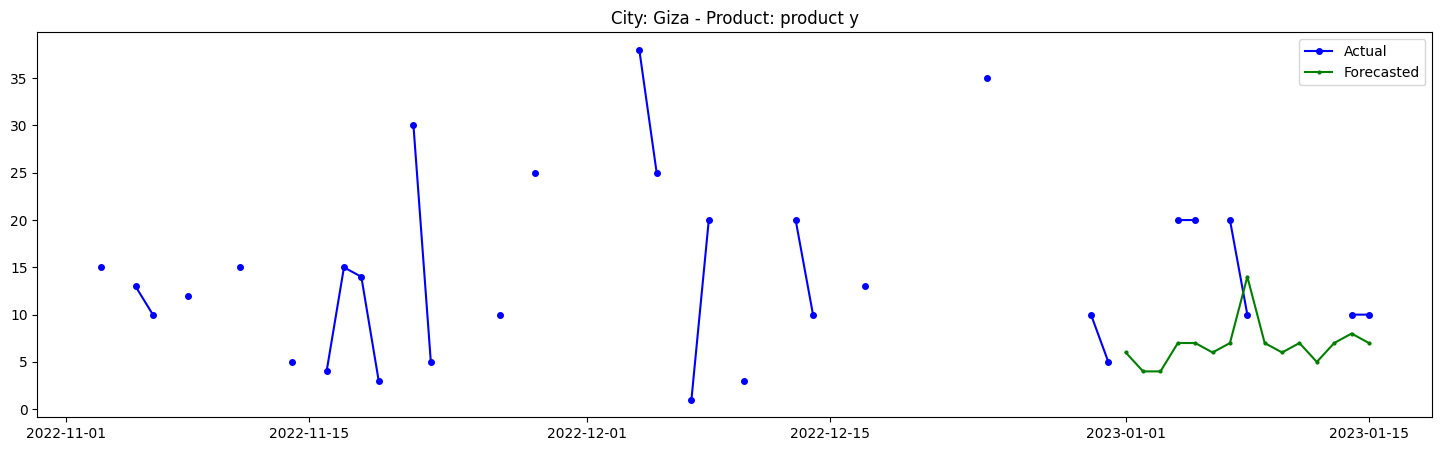

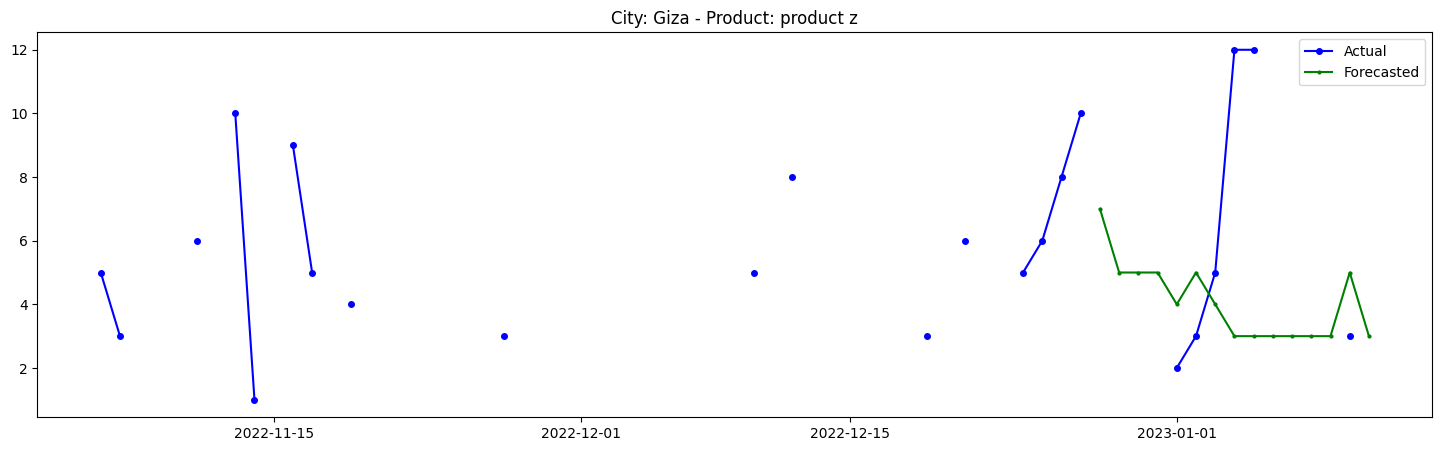

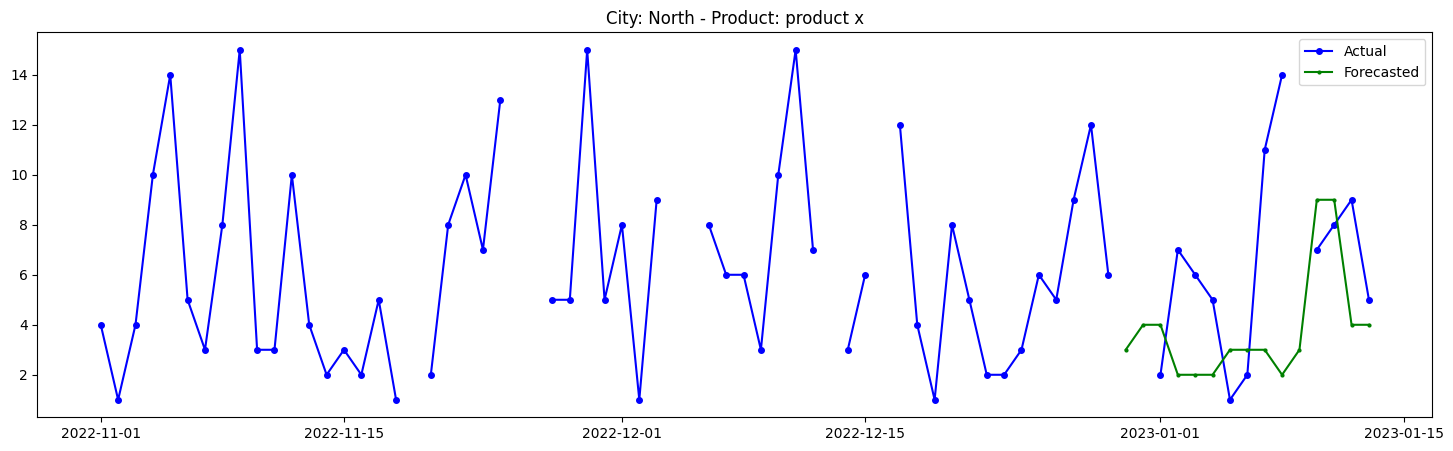

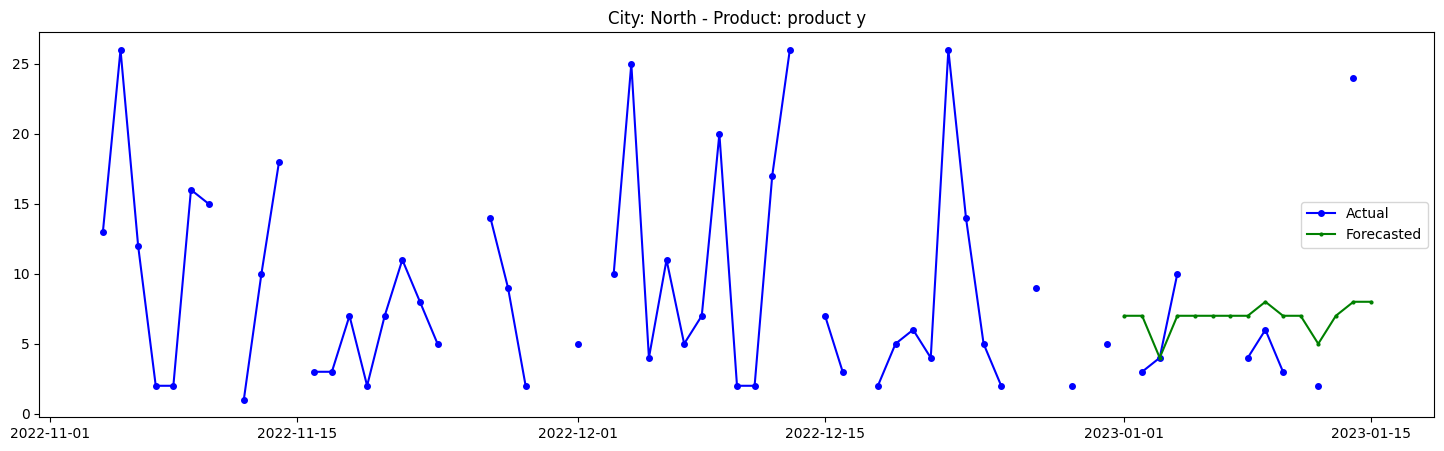

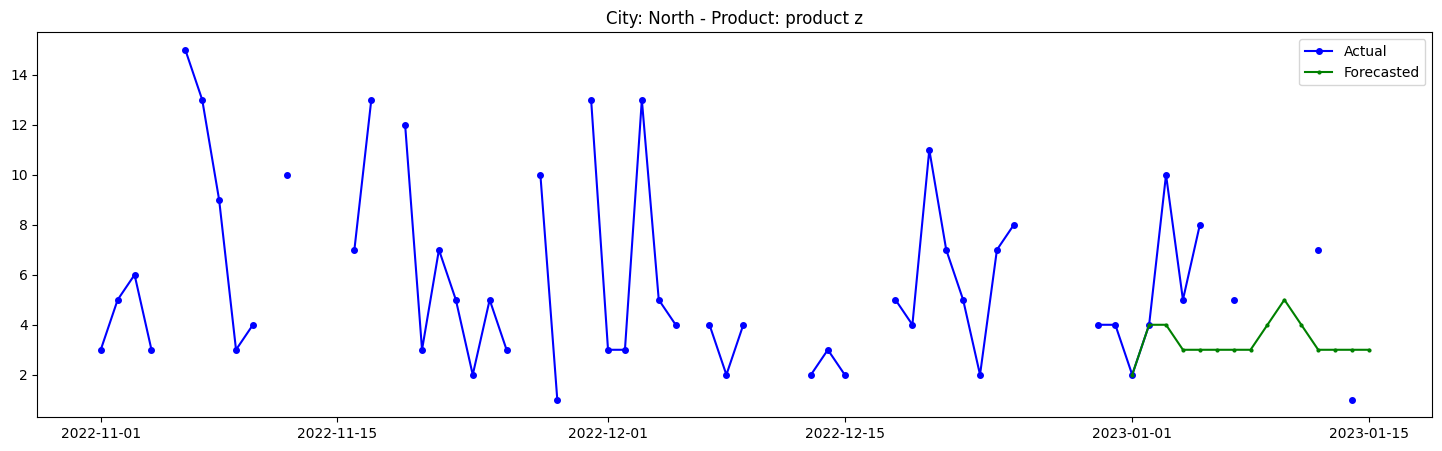

In [95]:
plot_original_vs_forecast(training_data, predicted, cities, products, start= "2022-11-01", is_interpolated= is_interpolated)

In [96]:
def calculate_metrics(original, forecasted, cities, products):
    """
    Calculate Mean Absolute Percentage Error for the given dataframes
    """
    errors = []
    for city in cities:
        for product in products:
            org = original.query('city == @city & product_name == @product').copy().rename(columns= {'quantity': 'quantity_actual'})
            predicted = forecasted.query('city == @city & product_name == @product').copy().rename(columns= {'quantity': 'quantity_forecasted'})
            total = pd.merge(org, predicted, left_index= True, right_index= True)
            rmse = root_mean_squared_error(total['quantity_actual'], total['quantity_forecasted'])
            mae = mean_absolute_error(total['quantity_actual'], total['quantity_forecasted'])
            errors.append(
                {'City': city,
                 'Product': product,
                 'RMSE': rmse,
                 'MAE': mae}
            )
            
    return pd.DataFrame(errors)

In [97]:
calculate_metrics(training_data, predicted, cities, products)

City    Product      RMSE       MAE
0  Cairo  product x  4.326001  3.285714
1  Cairo  product y  0.577350  0.333333
2  Cairo  product z  1.095445  0.800000
3   Giza  product x  3.197221  2.666667
4   Giza  product y  9.451631  8.000000
5   Giza  product z  5.400617  4.166667
6  North  product x  4.983305  3.833333
7  North  product y  6.314665  4.375000
8  North  product z  3.335416  2.625000

In [98]:
np.mean(calculate_metrics(training_data, predicted, cities, products).drop(['City', 'Product'], axis= 1), axis= 0)

RMSE    4.297961
MAE     3.342857
dtype: float64

# Forecasting Upcoming 10 Days

In [99]:
def plot_forecasted(forecasted: pd.DataFrame, cities: list, products: list, n_days: int) -> None:
    _ , axs = plt.subplots(len(cities), len(products), figsize= (18, 15))
    axs = axs.flatten()
    ax_idx = 0
    
    for city in cities:
        for product in products:
            ax = axs[ax_idx]
            temp = forecasted.query('city == @city and product_name == @product').copy()

            _ = ax.plot(temp['quantity'], label= 'Forecasted', color= 'red', marker= 'o', markersize= 3)
            ax.set_title(f"Forecasting {n_days} days for {product} in {city}")
            loc = mdates.DayLocator(interval=1)
            ax.xaxis.set_major_locator(loc)
            fmt = mdates.DateFormatter('%d\n%b')
            ax.xaxis.set_major_formatter(fmt)
            ax_idx += 1             

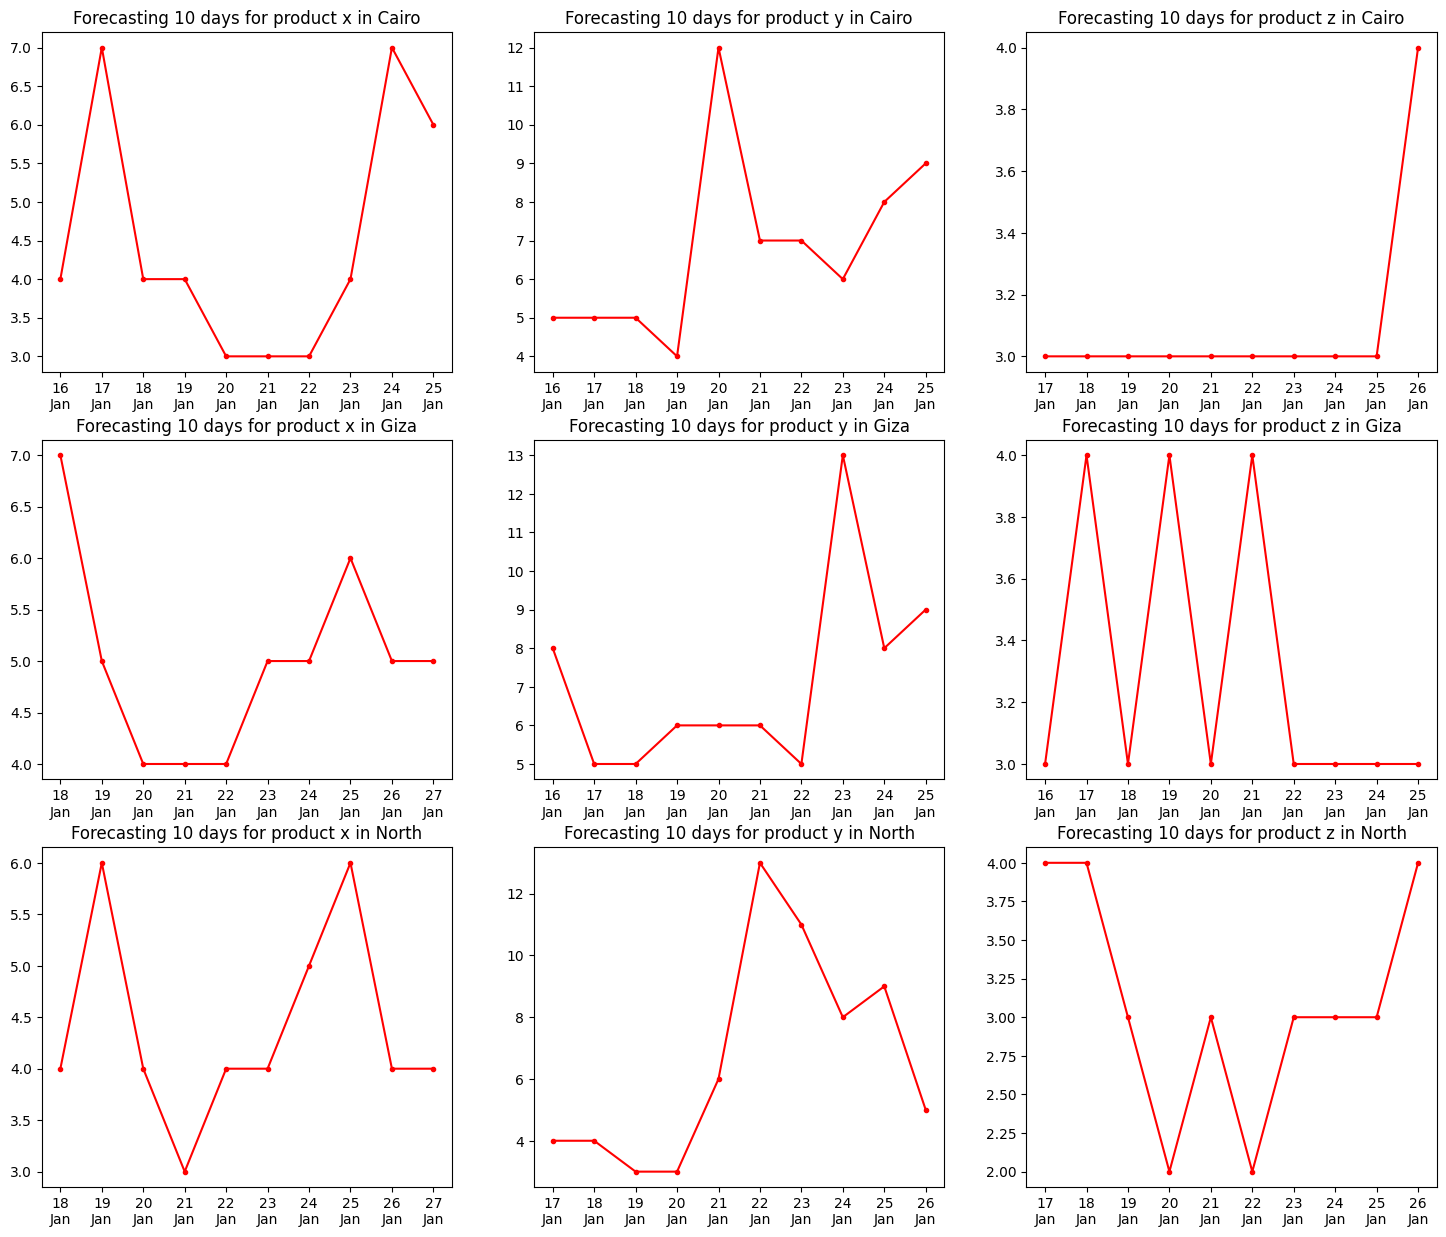

In [100]:
n_days = 10
final_data = training_data.copy()
if is_interpolated: final_data.drop('was_missing', axis= 1, inplace= True)
forecasted = recursive_forecast(final_data, model, periods, cities, products, is_interpolated= is_interpolated, n_days= n_days)
plot_forecasted(forecasted, cities, products, n_days)